In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 590ms/step - accuracy: 0.4914 - loss: 0.7197 - val_accuracy: 0.5000 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 556ms/step - accuracy: 0.4635 - loss: 0.6915 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 547ms/step - accuracy: 0.6666 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 546ms/step - accuracy: 0.7370 - loss: 0.6900 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 542ms/step - accuracy: 0.5858 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 556ms/step - accuracy: 0.2611 - loss: 0.6972 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 2.0000e-04
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 551ms/step - accuracy

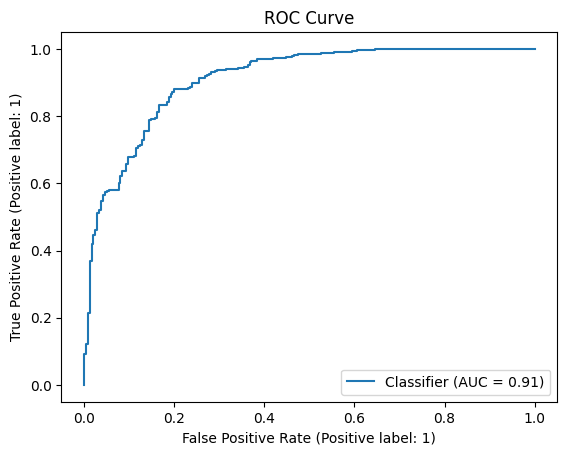

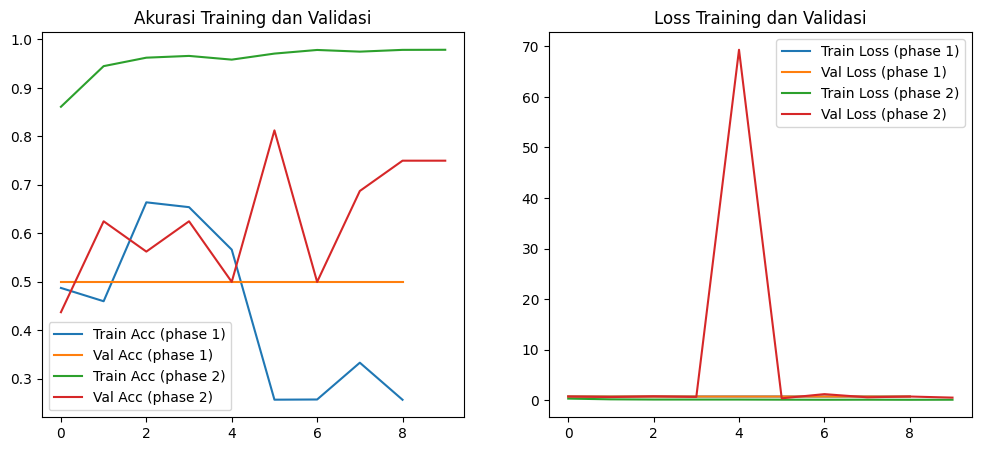

ValueError: No such layer: top_conv. Existing layers are: ['efficientnetb0', 'global_average_pooling2d_4', 'dense_8', 'dropout_4', 'dense_9'].

In [23]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models, optimizers
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import matplotlib as mpl

# Base directory dataset (pastikan struktur direktori sesuai dataset Pneumonia)
base_dir = "/kaggle/input/pneumonia"
train_dir = os.path.join(base_dir, "Pneumonia/train")
val_dir = os.path.join(base_dir, "Pneumonia/val")
test_dir = os.path.join(base_dir, "Pneumonia/test")

# Verifikasi direktori
for d in [train_dir, val_dir, test_dir]:
    if not os.path.exists(d):
        raise FileNotFoundError(f"Directory not found: {d}")

# ============================
# Data Preparation & Augmentasi
# ============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# ============================
# Class Weights (imbalance)
# ============================
classes = np.unique(train_gen.classes)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_gen.classes)
class_weights = dict(enumerate(class_weights))

# ============================
# Model: EfficientNetB0
# ============================
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Bekukan bobot pretrained

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Keluaran sigmoid untuk klasifikasi biner
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ============================
# Callbacks: EarlyStopping & ReduceLROnPlateau
# ============================
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# ============================
# Training awal dengan Frozen Base
# ============================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

# ============================
# Fine-Tuning: buka kembali base_model
# ============================
base_model.trainable = True
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

# ============================
# Evaluasi pada Test Set
# ============================
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
target_names = list(test_gen.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# ROC AUC Score
roc_auc = roc_auc_score(y_true, y_pred_probs)
print(f"AUROC: {roc_auc:.2f}")

# Plot ROC Curve
RocCurveDisplay.from_predictions(y_true, y_pred_probs)
plt.title("ROC Curve")
plt.show()

# Plot Training History
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc (phase 1)')
plt.plot(history.history['val_accuracy'], label='Val Acc (phase 1)')
plt.plot(history_fine.history['accuracy'], label='Train Acc (phase 2)')
plt.plot(history_fine.history['val_accuracy'], label='Val Acc (phase 2)')
plt.title("Akurasi Training dan Validasi")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss (phase 1)')
plt.plot(history.history['val_loss'], label='Val Loss (phase 1)')
plt.plot(history_fine.history['loss'], label='Train Loss (phase 2)')
plt.plot(history_fine.history['val_loss'], label='Val Loss (phase 2)')
plt.title("Loss Training dan Validasi")
plt.legend()
plt.show()

# ============================
# Fungsi Grad-CAM
# ============================
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        # untuk klasifikasi biner, kelas positif pada indeks 0
        class_channel = predictions[:, 0]
    # Gradien output kelas terhadap peta fitur terakhir
    grads = tape.gradient(class_channel, conv_outputs)
    # rata-rata gradien untuk setiap channel peta fitur
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # kalikan setiap saluran peta fitur dengan bobotnya
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    # normalisasi 0..1
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()

def save_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load citra asli
    img = load_img(img_path)
    img = img_to_array(img)
    # Rescale heatmap ke 0-255 dan terapkan colormap Jet
    heatmap_uint8 = np.uint8(255 * heatmap)
    jet_colors = mpl.cm.get_cmap("jet")(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_uint8]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)
    # Superimpose heatmap ke citra asli
    superimposed = jet_heatmap * alpha + img
    superimposed = tf.keras.preprocessing.image.array_to_img(superimposed)
    superimposed.save(cam_path)

# ============================
# Hasilkan Grad-CAM Heatmap pada Beberapa Contoh Gambar Test
# ============================
last_conv_layer = "top_conv"  # nama lapisan conv terakhir pada EfficientNetB0
gradcam_dir = "gradcam_outputs"
os.makedirs(gradcam_dir, exist_ok=True)

filenames = test_gen.filenames  # daftar file relatif dalam test_dir
for i, fname in enumerate(filenames[:5]):  # misalnya 5 gambar pertama
    img_path = os.path.join(test_dir, fname)
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    # Hasilkan heatmap Grad-CAM
    heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name=last_conv_layer)
    cam_path = os.path.join(gradcam_dir, f"gradcam_{i}.jpg")
    save_gradcam(img_path, heatmap, cam_path=cam_path, alpha=0.4)
    print(f"Saved Grad-CAM for {fname} as {cam_path}")


In [27]:
import os, glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import matplotlib.pyplot as plt

model = load_model('/kaggle/working/pneumonia_model_final.keras')

# Temukan sub-model EfficientNetB0 dalam model Sequential
base_model = None
for layer in model.layers:
    if isinstance(layer, tf.keras.Model):
        base_model = layer
        break

# Cari layer Conv2D terakhir di base_model
last_conv = None
for layer in reversed(base_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv = layer.name
        break

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    conv_layer = base_model.get_layer(last_conv_layer_name)
    grad_model = Model([model.inputs], [conv_layer.output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()

out_dir = '/kaggle/working/gradcam_outputs'
os.makedirs(out_dir, exist_ok=True)

new_images_dir = "/kaggle/input/data-radiolog/data pneumonia radiolog 111124/data pneumonia radiolog 111124/data numbered14-10-24"
for img_path in glob.glob(os.path.join(new_images_dir, '*')):
    if not img_path.lower().endswith(('.jpg','.jpeg','.png')):
        continue
    img = load_img(img_path, target_size=(224,224))
    x = img_to_array(img)/255.0
    x = np.expand_dims(x,0)
    pred = model.predict(x)[0][0]
    label = 'Pneumonia' if pred>0.5 else 'Normal'
    conf = pred if pred>0.5 else 1-pred

    heatmap = make_gradcam_heatmap(x, model, last_conv)
    heatmap_uint = np.uint8(255 * heatmap)
    heatmap_resized = cv2.resize(heatmap_uint, (224,224))
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    orig = cv2.imread(img_path)
    orig = cv2.resize(orig, (224,224))
    overlay = cv2.addWeighted(orig, 0.6, heatmap_color, 0.4, 0)

    fname = os.path.basename(img_path)
    out_path = os.path.join(out_dir, f'gradcam_{fname}')
    cv2.imwrite(out_path, overlay)

    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"{fname}: {label} ({conf:.2f})")
    plt.axis('off')
    plt.show()


In [28]:
import shutil, os

src = "/kaggle/input/data-radiolog/data pneumonia radiolog 111124/data pneumonia radiolog 111124/data numbered14-10-24"
dst = "/kaggle/working/new_images"
if not os.path.exists(dst):
    shutil.copytree(src, dst)


In [29]:
import os
print("Files in new_images:", os.listdir("/kaggle/working/new_images")[:10])


Files in new_images: ['26-09 (Sudah Blur)', '09-09', '12-09', '17-09', '20-09', '19-09', '10-09', '25-09', '18-09', '23-09']


In [30]:
import os, glob, numpy as np, tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2, matplotlib.pyplot as plt

# Load model .keras
model = load_model('/kaggle/working/pneumonia_model_final.keras')

# Ambil sub-model EfficientNetB0
base_model = None
for l in model.layers:
    if isinstance(l, tf.keras.Model):
        base_model = l
        break

# Temukan layer Conv2D terakhir
for layer in reversed(base_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv = layer.name
        break

def make_gradcam_heatmap(x, model, conv_name):
    conv_layer = base_model.get_layer(conv_name)
    grad_model = Model([model.inputs], [conv_layer.output, model.output])
    with tf.GradientTape() as tape:
        conv_out, pred = grad_model(x)
        loss = pred[:,0]
    grads = tape.gradient(loss, conv_out)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))
    conv_out = conv_out[0]
    heat = conv_out @ pooled[...,tf.newaxis]
    heat = tf.squeeze(heat)
    heat = tf.maximum(heat, 0) / (tf.math.reduce_max(heat) + tf.keras.backend.epsilon())
    return heat.numpy()

out_dir = '/kaggle/working/gradcam_outputs'
os.makedirs(out_dir, exist_ok=True)

for img_path in glob.glob('/kaggle/working/new_images/*'):
    if not img_path.lower().endswith(('.jpg','.jpeg','.png')): continue
    img = load_img(img_path, target_size=(224,224))
    x = img_to_array(img)/255.0
    x = np.expand_dims(x,0)
    pred = model.predict(x)[0][0]
    lbl = 'Pneumonia' if pred>0.5 else 'Normal'
    hm = make_gradcam_heatmap(x, model, last_conv)
    hm_uint = np.uint8(255*hm)
    hm_res = cv2.resize(hm_uint, (224,224))
    hm_col = cv2.applyColorMap(hm_res, cv2.COLORMAP_JET)
    orig = cv2.imread(img_path); orig = cv2.resize(orig,(224,224))
    overlay = cv2.addWeighted(orig,0.6,hm_col,0.4,0)
    out_path = os.path.join(out_dir, f'gradcam_{os.path.basename(img_path)}')
    cv2.imwrite(out_path, overlay)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"{lbl} ({pred:.2f})"); plt.axis('off'); plt.show()


In [31]:
!ls -lh /kaggle/working/gradcam_outputs


total 0


In [32]:
import os, shutil, glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import matplotlib.pyplot as plt

# copy input folder to working
src = "/kaggle/input/data-radiolog/data pneumonia radiolog 111124/data pneumonia radiolog 111124/data numbered14-10-24"
dst = "/kaggle/working/new_images"
if not os.path.exists(dst):
    shutil.copytree(src, dst)

# load model
model = load_model('/kaggle/working/pneumonia_model_final.keras')

# find base_model inside model
base_model = next(l for l in model.layers if isinstance(l, tf.keras.Model))

# find last Conv2D layer name
last_conv = next(layer.name for layer in reversed(base_model.layers) if isinstance(layer, tf.keras.layers.Conv2D))

# Grad-CAM function
def make_gradcam_heatmap(x, model, conv_name):
    conv_layer = base_model.get_layer(conv_name)
    grad_model = Model([model.inputs], [conv_layer.output, model.output])
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(x)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]
    grads = tape.gradient(loss, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_out = conv_out[0]
    heatmap = conv_out @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap,0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()

# process images
out_dir = '/kaggle/working/gradcam_outputs'
os.makedirs(out_dir, exist_ok=True)
for img_path in glob.glob(os.path.join(dst, '*')):
    if not img_path.lower().endswith(('.jpg','.jpeg','.png')): continue
    img = load_img(img_path, target_size=(224,224))
    x = img_to_array(img)/255.0
    x = np.expand_dims(x,0)
    pred = model.predict(x)[0][0]
    label = 'Pneumonia' if pred>0.5 else 'Normal'
    conf = pred if pred>0.5 else 1-pred

    hm = make_gradcam_heatmap(x, model, last_conv)
    print("Heatmap max/min:", hm.max(), hm.min())
    plt.figure(); plt.title("Raw heatmap"); plt.imshow(hm, cmap='jet'); plt.colorbar(); plt.show()

    hm_uint = np.uint8(255*hm)
    hm_res = cv2.resize(hm_uint, (224,224))
    hm_col = cv2.applyColorMap(hm_res, cv2.COLORMAP_JET)
    orig = cv2.imread(img_path); orig = cv2.resize(orig,(224,224))
    overlay = cv2.addWeighted(orig,0.6,hm_col,0.4,0)

    out_path = os.path.join(out_dir, f'gradcam_{os.path.basename(img_path)}')
    cv2.imwrite(out_path, overlay)
    plt.figure(); plt.title(f"{label} ({conf:.2f})"); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.show()


In [33]:
import os, glob, shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import matplotlib.pyplot as plt

# 1. Salin folder input tanpa spasi ke working
src = "/kaggle/input/data-radiolog/data pneumonia radiolog 111124/data pneumonia radiolog 111124/data numbered14-10-24"
dst = "/kaggle/working/new_images"
if not os.path.exists(dst):
    shutil.copytree(src, dst)

# 2. Load model .keras
model = load_model('/kaggle/working/pneumonia_model_final.keras')

# 3. Ambil base_model (EfficientNetB0) di dalam model
base_model = model.get_layer('efficientnetb0')

# 4. Tentukan layer Conv2D terakhir
last_conv = None
for layer in reversed(base_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv = layer.name
        break

# 5. Grad‑CAM heatmap function
def make_gradcam_heatmap(img_array, model, conv_name):
    conv_layer = base_model.get_layer(conv_name)
    grad_model = Model([model.inputs], [conv_layer.output, model.output])
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]
    grads = tape.gradient(loss, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_out = conv_out[0]
    heatmap = conv_out @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()

# 6. Loop gambar dan simpan heatmap + overlay
out_dir = '/kaggle/working/gradcam_outputs'
os.makedirs(out_dir, exist_ok=True)

for img_path in glob.glob(os.path.join(dst, '*')):
    if not img_path.lower().endswith(('.jpg','.jpeg','.png')):
        continue

    # preprocess
    img = load_img(img_path, target_size=(224,224))
    x = img_to_array(img) / 255.0
    x = np.expand_dims(x, 0)

    # prediksi
    pred = model.predict(x)[0][0]
    label = 'Pneumonia' if pred > 0.5 else 'Normal'
    conf  = pred if pred>0.5 else 1-pred

    # hitung heatmap
    heatmap = make_gradcam_heatmap(x, model, last_conv)
    print(f"Heatmap range: min={heatmap.min():.3f}, max={heatmap.max():.3f}")

    # tampilkan raw heatmap
    plt.figure(figsize=(4,4))
    plt.title("Raw Grad-CAM")
    plt.imshow(heatmap, cmap='jet')
    plt.axis('off')
    plt.show()

    # overlay
    hm_uint = np.uint8(255 * heatmap)
    hm_res  = cv2.resize(hm_uint, (224,224))
    hm_col  = cv2.applyColorMap(hm_res, cv2.COLORMAP_JET)
    orig    = cv2.imread(img_path)
    orig    = cv2.resize(orig, (224,224))
    overlay = cv2.addWeighted(orig, 0.6, hm_col, 0.4, 0)

    # simpan dan tampilkan overlay
    fname = os.path.basename(img_path)
    out_path = os.path.join(out_dir, f'gradcam_{fname}')
    cv2.imwrite(out_path, overlay)
    plt.figure(figsize=(4,4))
    plt.title(f"{label} ({conf:.2f})")
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


In [61]:
import os, shutil, glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import matplotlib.pyplot as plt

# 1. Copy input folder (hapus spasi) ke working
src = "/kaggle/input/data-radiolog/data pneumonia radiolog 111124/data pneumonia radiolog 111124/data numbered14-10-24/26-09 (Sudah Blur)/BLM BLUR (Sudah Blur)"
dst = "/kaggle/working/new_images"
if not os.path.exists(dst):
    shutil.copytree(src, dst)

# 2. Load model .keras
model = load_model('/kaggle/working/pneumonia_model_final.keras')

# 3. Temukan base_model (EfficientNetB0) di dalam model
base_model = None
for layer in model.layers:
    if hasattr(layer, 'layers') and any(isinstance(l, tf.keras.layers.Conv2D) for l in layer.layers):
        base_model = layer
        break

# 4. Temukan nama layer Conv2D terakhir di base_model
last_conv = None
for layer in reversed(base_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv = layer.name
        break

# 5. Fungsi generate Grad-CAM heatmap
def make_gradcam_heatmap(x, model, conv_name):
    conv_layer = base_model.get_layer(conv_name)
    grad_model = Model([model.inputs], [conv_layer.output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(x)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()

# 6. Proses setiap gambar dan simpan heatmap
out_dir = "/kaggle/working/gradcam_outputs"
os.makedirs(out_dir, exist_ok=True)

for img_path in glob.glob(os.path.join(dst, "*")):
    if not img_path.lower().endswith(('.jpg','.jpeg','.png')):
        continue

    # a) Preprocess
    img = load_img(img_path, target_size=(224,224))
    x = img_to_array(img) / 255.0
    x = np.expand_dims(x, 0)

    # b) Prediksi
    pred = model.predict(x, verbose=0)[0][0]
    label = "Pneumonia" if pred > 0.5 else "Normal"
    conf  = pred if pred > 0.5 else 1 - pred

    # c) Buat heatmap
    heatmap = make_gradcam_heatmap(x, model, last_conv)
    print(f"{os.path.basename(img_path)} heatmap range: {heatmap.min():.3f}–{heatmap.max():.3f}")

    # d) Tampilkan raw heatmap
    plt.figure(figsize=(4,4))
    plt.title("Raw Grad-CAM")
    plt.imshow(heatmap, cmap="jet")
    plt.axis("off")
    plt.show()

    # e) Overlay heatmap
    hm_uint = np.uint8(255 * heatmap)
    hm_res  = cv2.resize(hm_uint, (224,224))
    hm_col  = cv2.applyColorMap(hm_res, cv2.COLORMAP_JET)
    orig    = cv2.imread(img_path)
    orig    = cv2.resize(orig, (224,224))
    overlay = cv2.addWeighted(orig, 0.6, hm_col, 0.4, 0)

    # f) Simpan & tampilkan overlay
    out_path = os.path.join(out_dir, f"gradcam_{os.path.basename(img_path)}")
    cv2.imwrite(out_path, overlay)
    plt.figure(figsize=(4,4))
    plt.title(f"{label} ({conf:.2f})")
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


In [62]:
import os, glob
from IPython.display import display
from PIL import Image

out_dir = "/kaggle/working/gradcam_outputs/"

# 1. List all files
files = sorted(glob.glob(os.path.join(out_dir, "*")))
print("Files in gradcam_outputs:")
for f in files:
    print("-", os.path.basename(f))

# 2. Display first 6 images inline
for img_path in files[:6]:
    img = Image.open(img_path)
    print(os.path.basename(img_path))
    display(img)


Files in gradcam_outputs:


In [63]:
!ls -lh /kaggle/working/gradcam_outputs


total 0


In [70]:
import os, glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2

# 1. Verifikasi folder working dan isi new_images
print("new_images exists?", os.path.exists("/kaggle/working/new_images/26-09 (Sudah Blur)/BLM BLUR (Sudah Blur)/1128. ALFONS WIBOWO KURNIA.jpg"))
print("new_images contents:", os.listdir("/kaggle/working/new_images/26-09 (Sudah Blur)/BLM BLUR (Sudah Blur)")[:5])

# 2. Verifikasi model
model_path = "/kaggle/working/pneumonia_model_final.keras"
print("Model exists?", os.path.exists(model_path))

# 3. Load model dan ambil base_model
model = load_model(model_path)
base_model = next(l for l in model.layers if hasattr(l, 'layers'))

# 4. Temukan last conv layer
last_conv = next((layer.name for layer in reversed(base_model.layers)
                  if isinstance(layer, tf.keras.layers.Conv2D)), None)
print("Last conv layer:", last_conv)

# 5. Coba generate satu heatmap tanpa menyimpan ke disk
img_files = glob.glob("/kaggle/working/new_images/*")
img_path = img_files[0]
print("Testing on:", img_path)
x = img_to_array(load_img(img_path, target_size=(224,224))) / 255.0
x = np.expand_dims(x,0)

# 6. Definisi Grad‑CAM cepat
def make_gradcam_heatmap(x, model, conv_name):
    conv_layer = base_model.get_layer(conv_name)
    grad_model = Model([model.inputs], [conv_layer.output, model.output])
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(x)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]
    grads = tape.gradient(loss, conv_out)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))
    conv_out = conv_out[0]
    heat = conv_out @ pooled[...,tf.newaxis]
    heat = tf.squeeze(heat)
    heat = heat.numpy()
    if heat.max() > 0:
        heat = np.maximum(heat, 0) / heat.max()
    return heat

heatmap = make_gradcam_heatmap(x, model, last_conv)
print("Heatmap stats:", heatmap.min(), heatmap.max())

# 7. Simpan overlay manual sekali
out_dir = "/kaggle/working/gradcam_outputs"
os.makedirs(out_dir, exist_ok=True)
orig = cv2.imread(img_path)
orig = cv2.resize(orig, (224,224))
hm_uint = np.uint8(255 * heatmap)
hm_col = cv2.applyColorMap(cv2.resize(hm_uint,(224,224)), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(orig, 0.6, hm_col, 0.4, 0)
out_path = os.path.join(out_dir, "test_overlay.jpg")
cv2.imwrite(out_path, overlay)

print("Saved one overlay to:", out_path)
print("Contents gradcam_outputs:", os.listdir(out_dir))


new_images exists? True
new_images contents: ['1205. SUTIKNO TIRTOKENTJONO_20240511.jpeg', '1204. SURYANTO_20220623.jpg', '1170. RADRO-20220704-2_20220704.jpg', '1157. M NASRUN_20220708.jpg', '1199. SABIL THPRAX_20240513.jpeg']
Model exists? True
Last conv layer: top_conv
Testing on: /kaggle/working/new_images/26-09 (Sudah Blur)


IsADirectoryError: [Errno 21] Is a directory: '/kaggle/working/new_images/26-09 (Sudah Blur)'

In [72]:
import os, glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2

# === 1. Path Setup ===
img_dir = "/kaggle/working/new_images/09-09/BLM BLUR"
model_path = "/kaggle/working/pneumonia_model_final.keras"
output_dir = "/kaggle/working/gradcam_outputs"
os.makedirs(output_dir, exist_ok=True)

# === 2. Ambil semua file gambar ===
img_files = glob.glob(os.path.join(img_dir, "**"), recursive=True)
img_files = [f for f in img_files if os.path.isfile(f) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]
print(f"Found image files: {len(img_files)} ->", img_files[:5])

# === 3. Load model ===
model = load_model(model_path)

# === 4. Cari layer Conv2D terakhir secara rekursif ===
def find_last_conv2d(model):
    last_conv_layer = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.models.Model):
            nested = find_last_conv2d(layer)
            if nested: last_conv_layer = nested
        elif isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer = layer
    return last_conv_layer

last_conv_layer = find_last_conv2d(model)
if not last_conv_layer:
    raise ValueError("No Conv2D layer found in the model.")
last_conv = last_conv_layer.name
print("Using last conv layer:", last_conv)

# === 5. Grad-CAM function ===
def make_gradcam_heatmap(x, model, conv_name):
    conv_layer = model.get_layer(conv_name)
    grad_model = Model([model.inputs], [conv_layer.output, model.output])
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(x)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]
    grads = tape.gradient(loss, conv_out)
    pooled = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_out = conv_out[0]
    heatmap = conv_out @ pooled[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()

# === 6. Loop seluruh gambar ===
for img_path in img_files:
    try:
        # Load dan preprocess
        x = img_to_array(load_img(img_path, target_size=(224, 224))) / 255.0
        x = np.expand_dims(x, 0)

        # Grad-CAM heatmap
        heatmap = make_gradcam_heatmap(x, model, last_conv)

        # Overlay dengan warna
        orig = cv2.resize(cv2.imread(img_path), (224, 224))
        hm_uint = np.uint8(255 * heatmap)
        hm_col = cv2.applyColorMap(cv2.resize(hm_uint, (224, 224)), cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(orig, 0.6, hm_col, 0.4, 0)

        # Simpan hasil
        filename = os.path.basename(img_path)
        out_path = os.path.join(output_dir, f"overlay_{filename}")
        cv2.imwrite(out_path, overlay)
        print(f"Processed: {filename}")
    except Exception as e:
        print(f"Error on {img_path}: {e}")

# === 7. Cek hasil output ===
print("Saved overlays:", os.listdir(output_dir)[:5])


Found image files: 127 -> ['/kaggle/working/new_images/09-09/BLM BLUR/370. VICLY GUNAWAN LUMINGKEWAS_20240603.jpeg', '/kaggle/working/new_images/09-09/BLM BLUR/235. AMAH_20230426.jpg', '/kaggle/working/new_images/09-09/BLM BLUR/275. DWI SARI FITRIASWATI_20240222.jpeg', '/kaggle/working/new_images/09-09/BLM BLUR/253. BERGIAT SIHOMBING_20240529.jpeg', '/kaggle/working/new_images/09-09/BLM BLUR/338. RADRO-20230922-1_20230922.jpeg']
Using last conv layer: top_conv
Error on /kaggle/working/new_images/09-09/BLM BLUR/370. VICLY GUNAWAN LUMINGKEWAS_20240603.jpeg: No such layer: top_conv. Existing layers are: ['input_layer_3', 'efficientnetb0', 'global_average_pooling2d_1', 'dense_2', 'dropout_1', 'dense_3'].
Error on /kaggle/working/new_images/09-09/BLM BLUR/235. AMAH_20230426.jpg: No such layer: top_conv. Existing layers are: ['input_layer_3', 'efficientnetb0', 'global_average_pooling2d_1', 'dense_2', 'dropout_1', 'dense_3'].
Error on /kaggle/working/new_images/09-09/BLM BLUR/275. DWI SARI FI


GENERATING GRAD-CAM VISUALIZATIONS
Using last conv layer: top_conv


ValueError: No such layer: top_conv. Existing layers are: ['input_layer_3', 'efficientnetb0', 'global_average_pooling2d_1', 'dense_2', 'dropout_1', 'dense_3'].

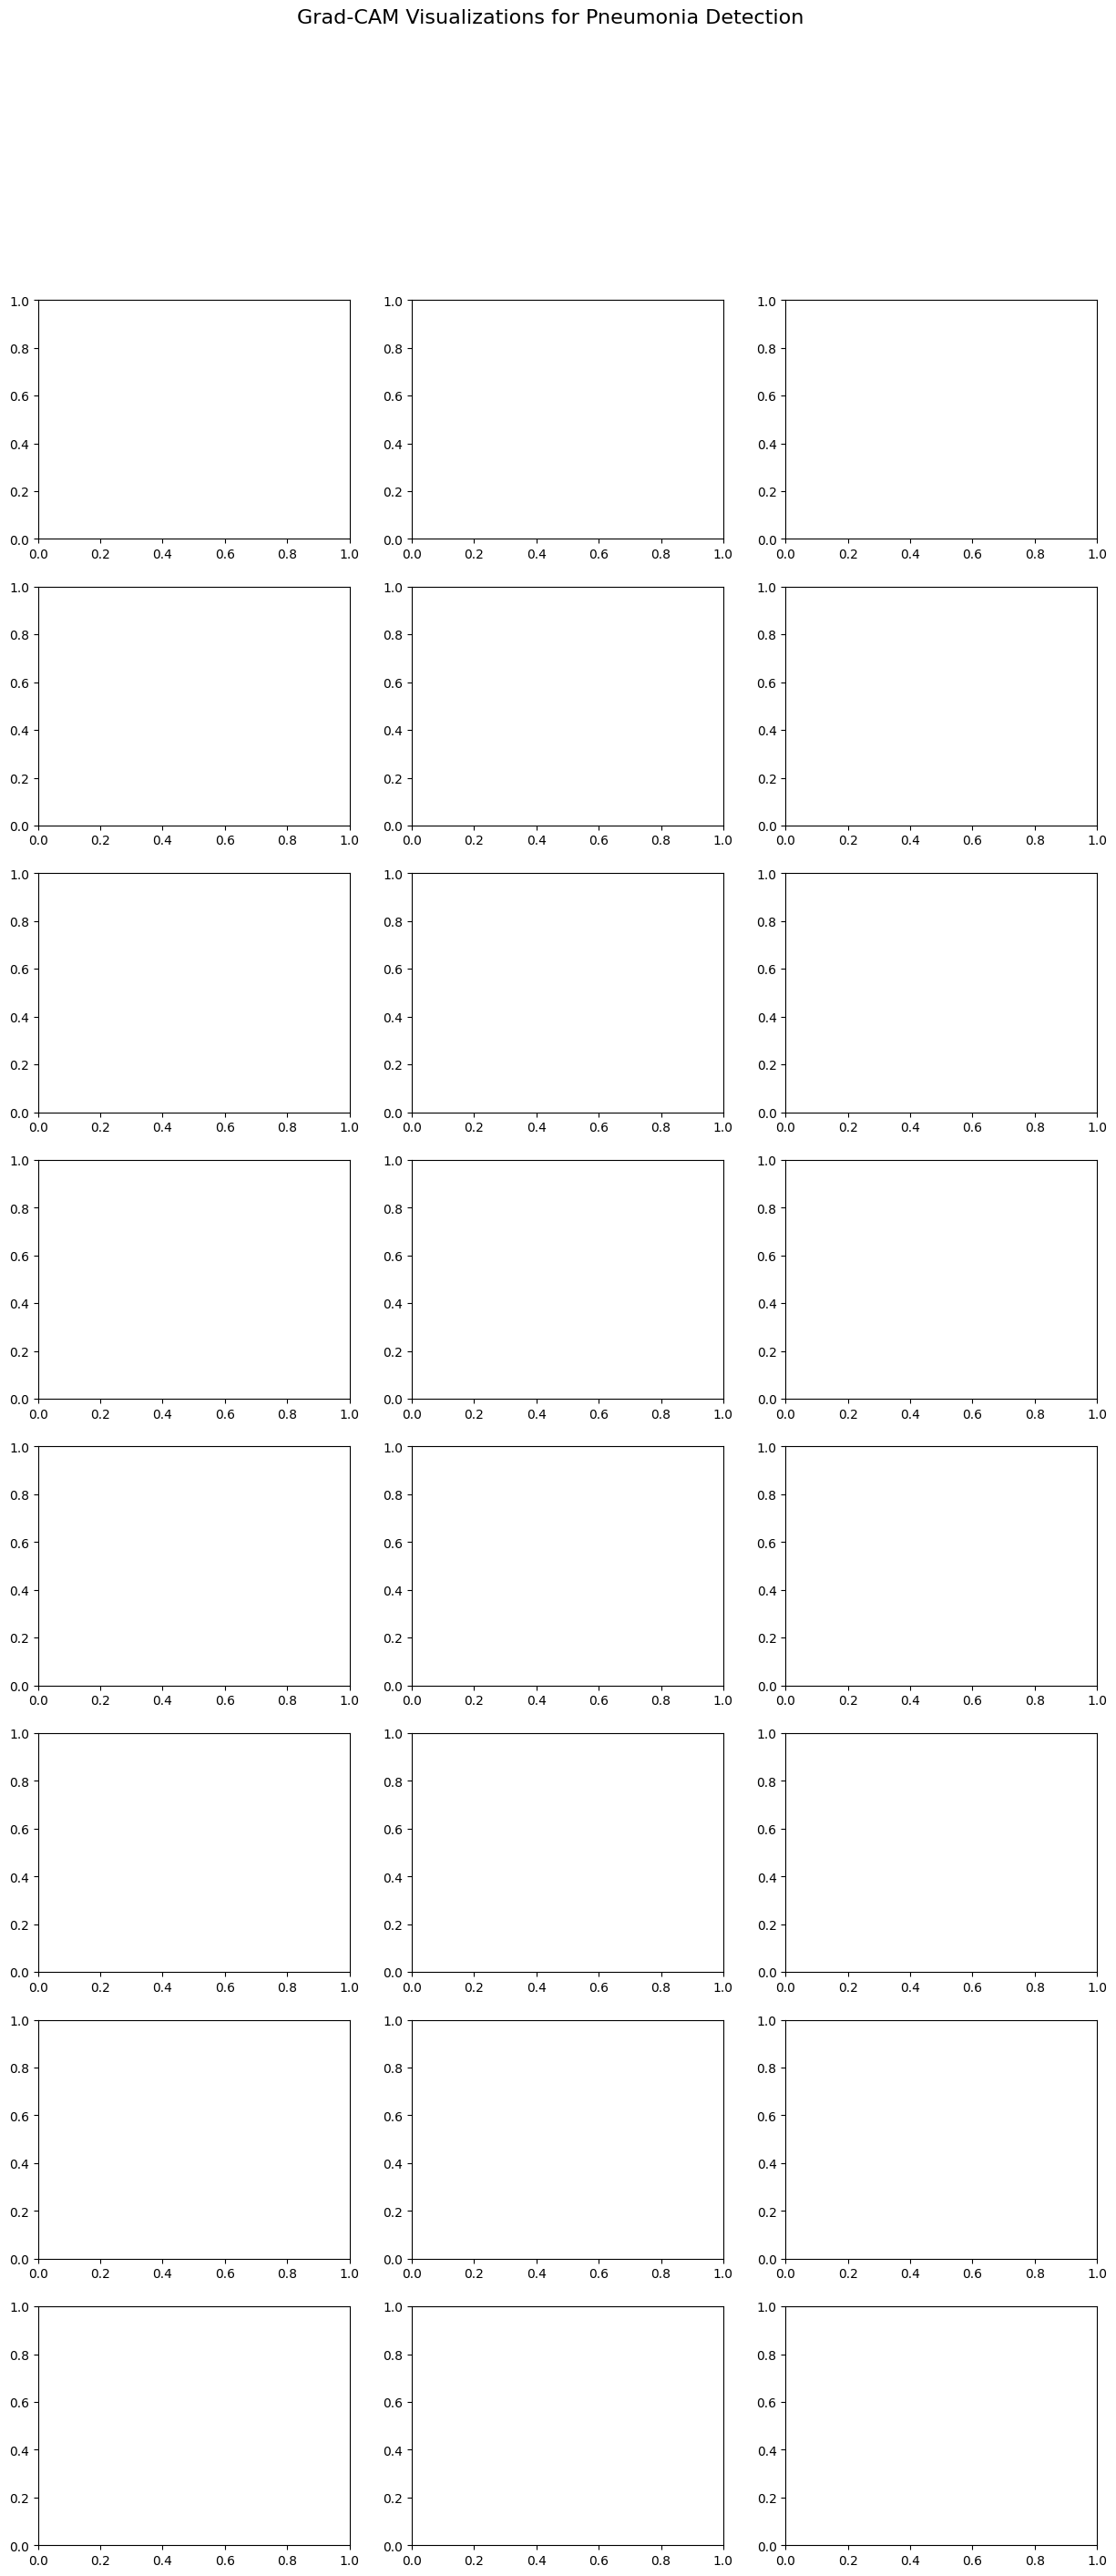

In [73]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Membuat heatmap Grad-CAM untuk visualisasi
    """
    # Model untuk mendapatkan output konvolusi dan prediksi
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Menghitung gradien
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, 0]  # untuk binary classification
    
    # Gradien output kelas terhadap peta fitur konvolusi terakhir
    grads = tape.gradient(class_channel, conv_outputs)
    
    # Pooling gradien secara spatial
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Mengalikan setiap channel dengan bobotnya
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalisasi heatmap ke rentang [0, 1]
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    """
    Menampilkan gambar dengan overlay heatmap Grad-CAM
    """
    # Load gambar asli
    img = load_img(img_path)
    img = img_to_array(img)
    
    # Resize heatmap ke ukuran gambar asli
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    
    # Terapkan colormap
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Superimpose heatmap pada gambar asli
    superimposed = heatmap_colored * alpha + img * (1 - alpha)
    superimposed = np.clip(superimposed, 0, 255).astype(np.uint8)
    
    return img.astype(np.uint8), heatmap_colored, superimposed

# ============================
# Menampilkan Grad-CAM untuk Beberapa Contoh Test
# ============================
print("\n" + "="*50)
print("GENERATING GRAD-CAM VISUALIZATIONS")
print("="*50)

# Mendapatkan layer konvolusi terakhir dari EfficientNetB0
last_conv_layer_name = None
for layer in base_model.layers[::-1]:
    if hasattr(layer, 'activation') and 'conv' in layer.name.lower():
        last_conv_layer_name = layer.name
        break

if last_conv_layer_name is None:
    # Fallback untuk EfficientNetB0
    last_conv_layer_name = "top_conv"

print(f"Using last conv layer: {last_conv_layer_name}")

# Reset test generator untuk mendapatkan file names
test_gen.reset()
filenames = test_gen.filenames
class_labels = list(test_gen.class_indices.keys())

# Pilih beberapa gambar untuk visualisasi (campuran dari kedua kelas)
num_samples = 8
selected_indices = []

# Ambil beberapa sampel dari masing-masing kelas
normal_count = 0
pneumonia_count = 0

for i, fname in enumerate(filenames):
    if normal_count >= num_samples//2 and pneumonia_count >= num_samples//2:
        break
    
    true_class = class_labels[y_true[i]]
    
    if true_class == 'NORMAL' and normal_count < num_samples//2:
        selected_indices.append(i)
        normal_count += 1
    elif true_class == 'PNEUMONIA' and pneumonia_count < num_samples//2:
        selected_indices.append(i)
        pneumonia_count += 1

# Visualisasi Grad-CAM
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4*num_samples))
fig.suptitle('Grad-CAM Visualizations for Pneumonia Detection', fontsize=16, y=0.98)

for idx, sample_idx in enumerate(selected_indices):
    fname = filenames[sample_idx]
    img_path = os.path.join(test_dir, fname)
    
    # Load dan preprocess gambar
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    
    # Prediksi
    prediction = model.predict(x, verbose=0)[0][0]
    predicted_class = 'PNEUMONIA' if prediction > 0.5 else 'NORMAL'
    true_class = class_labels[y_true[sample_idx]]
    
    # Generate heatmap
    heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name)
    
    # Display hasil
    original_img, heatmap_colored, superimposed = display_gradcam(img_path, heatmap)
    
    # Plot gambar asli
    axes[idx, 0].imshow(original_img)
    axes[idx, 0].set_title(f'Original\nTrue: {true_class}\nPred: {predicted_class} ({prediction:.3f})', fontsize=10)
    axes[idx, 0].axis('off')
    
    # Plot heatmap
    axes[idx, 1].imshow(heatmap_colored)
    axes[idx, 1].set_title('Grad-CAM\nHeatmap', fontsize=10)
    axes[idx, 1].axis('off')
    
    # Plot superimposed
    axes[idx, 2].imshow(superimposed)
    axes[idx, 2].set_title('Superimposed\nVisualization', fontsize=10)
    axes[idx, 2].axis('off')
    
    # Tambahkan border hijau untuk prediksi benar, merah untuk salah
    border_color = 'green' if predicted_class == true_class else 'red'
    for ax in axes[idx, :]:
        for spine in ax.spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(2)

plt.tight_layout()
plt.show()

# ============================
# Analisis Statistik Grad-CAM
# ============================
print("\n" + "="*50)
print("GRAD-CAM ANALYSIS SUMMARY")
print("="*50)

# Hitung statistik untuk semua gambar test
all_heatmaps = []
correct_predictions = 0

for i in range(min(50, len(filenames))):  # Analisis 50 gambar pertama
    fname = filenames[i]
    img_path = os.path.join(test_dir, fname)
    
    # Load dan preprocess gambar
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    
    # Prediksi
    prediction = model.predict(x, verbose=0)[0][0]
    predicted_class = 'PNEUMONIA' if prediction > 0.5 else 'NORMAL'
    true_class = class_labels[y_true[i]]
    
    if predicted_class == true_class:
        correct_predictions += 1
    
    # Generate heatmap
    heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name)
    all_heatmaps.append(heatmap)

print(f"Accuracy on analyzed samples: {correct_predictions}/{min(50, len(filenames))} = {correct_predictions/min(50, len(filenames))*100:.1f}%")
print(f"Average heatmap activation: {np.mean([np.mean(h) for h in all_heatmaps]):.3f}")
print(f"Max heatmap activation: {np.max([np.max(h) for h in all_heatmaps]):.3f}")

print("\n" + "="*50)
print("GRAD-CAM VISUALIZATION COMPLETED!")
print("="*50)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Starting initial training with frozen base model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 118s 593ms/step - accuracy: 0.4963 - loss: 0.7059 - val_accuracy: 0.5000 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 548ms/step - accuracy: 0.5086 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 544ms/step - accuracy: 0.2620 - loss: 0.6971 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 541ms/step - accuracy: 0.3739 - loss: 0.6948 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 542ms/step - accuracy: 0.4857 - loss: 0.6889 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 2.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 546ms/step - accuracy: 0.4729 - loss: 0.6878 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 2.0000e-04
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 549ms/step - accu

<Figure size 800x600 with 0 Axes>

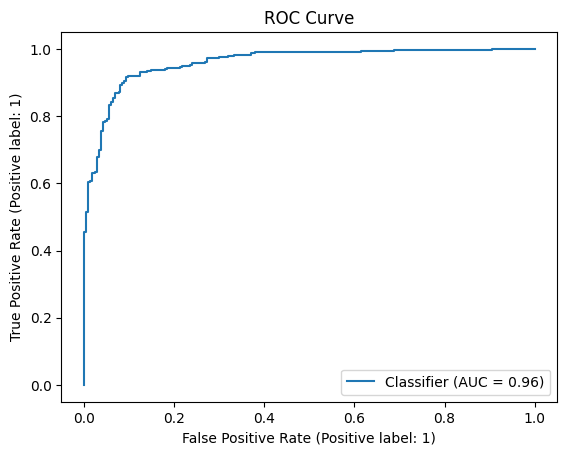

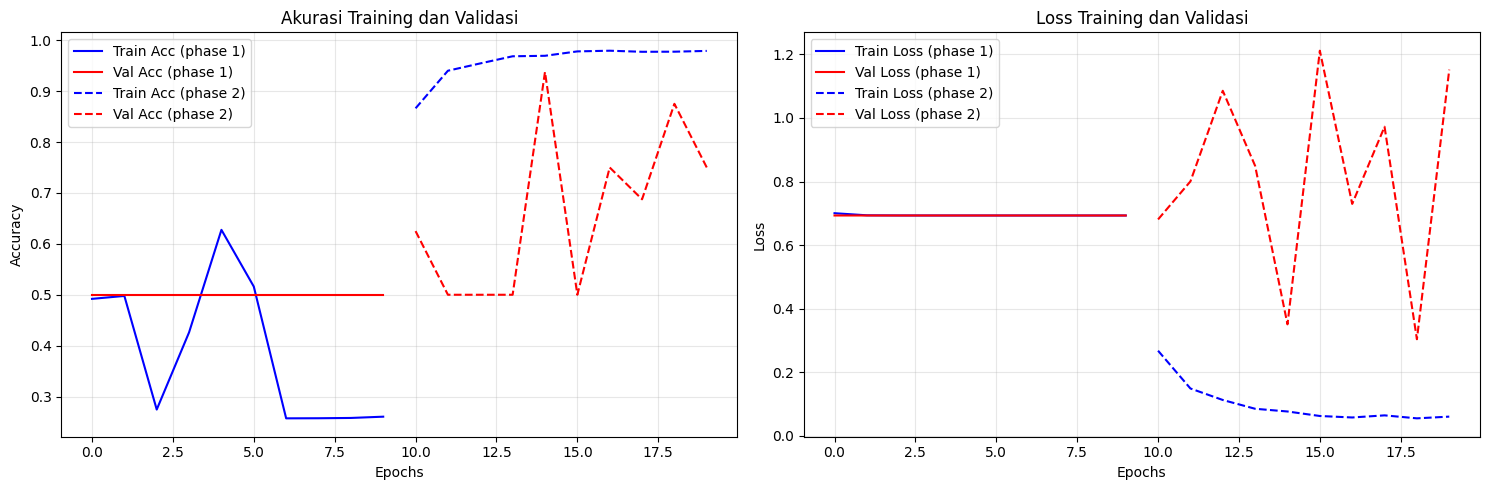


GENERATING GRAD-CAM VISUALIZATIONS
Available layers in base model:
- input_layer_10
- rescaling_10
- normalization_5
- rescaling_11
- stem_conv_pad
- stem_conv
- stem_bn
- stem_activation
- block1a_dwconv
- block1a_bn
- block1a_activation
- block1a_se_squeeze
- block1a_se_reshape
- block1a_se_reduce
- block1a_se_expand
- block1a_se_excite
- block1a_project_conv
- block1a_project_bn
- block2a_expand_conv
- block2a_expand_bn
- block2a_expand_activation
- block2a_dwconv_pad
- block2a_dwconv
- block2a_bn
- block2a_activation
- block2a_se_squeeze
- block2a_se_reshape
- block2a_se_reduce
- block2a_se_expand
- block2a_se_excite
- block2a_project_conv
- block2a_project_bn
- block2b_expand_conv
- block2b_expand_bn
- block2b_expand_activation
- block2b_dwconv
- block2b_bn
- block2b_activation
- block2b_se_squeeze
- block2b_se_reshape
- block2b_se_reduce
- block2b_se_expand
- block2b_se_excite
- block2b_project_conv
- block2b_project_bn
- block2b_drop
- block2b_add
- block3a_expand_conv
- block3

AttributeError: The layer sequential_4 has never been called and thus has no defined output.

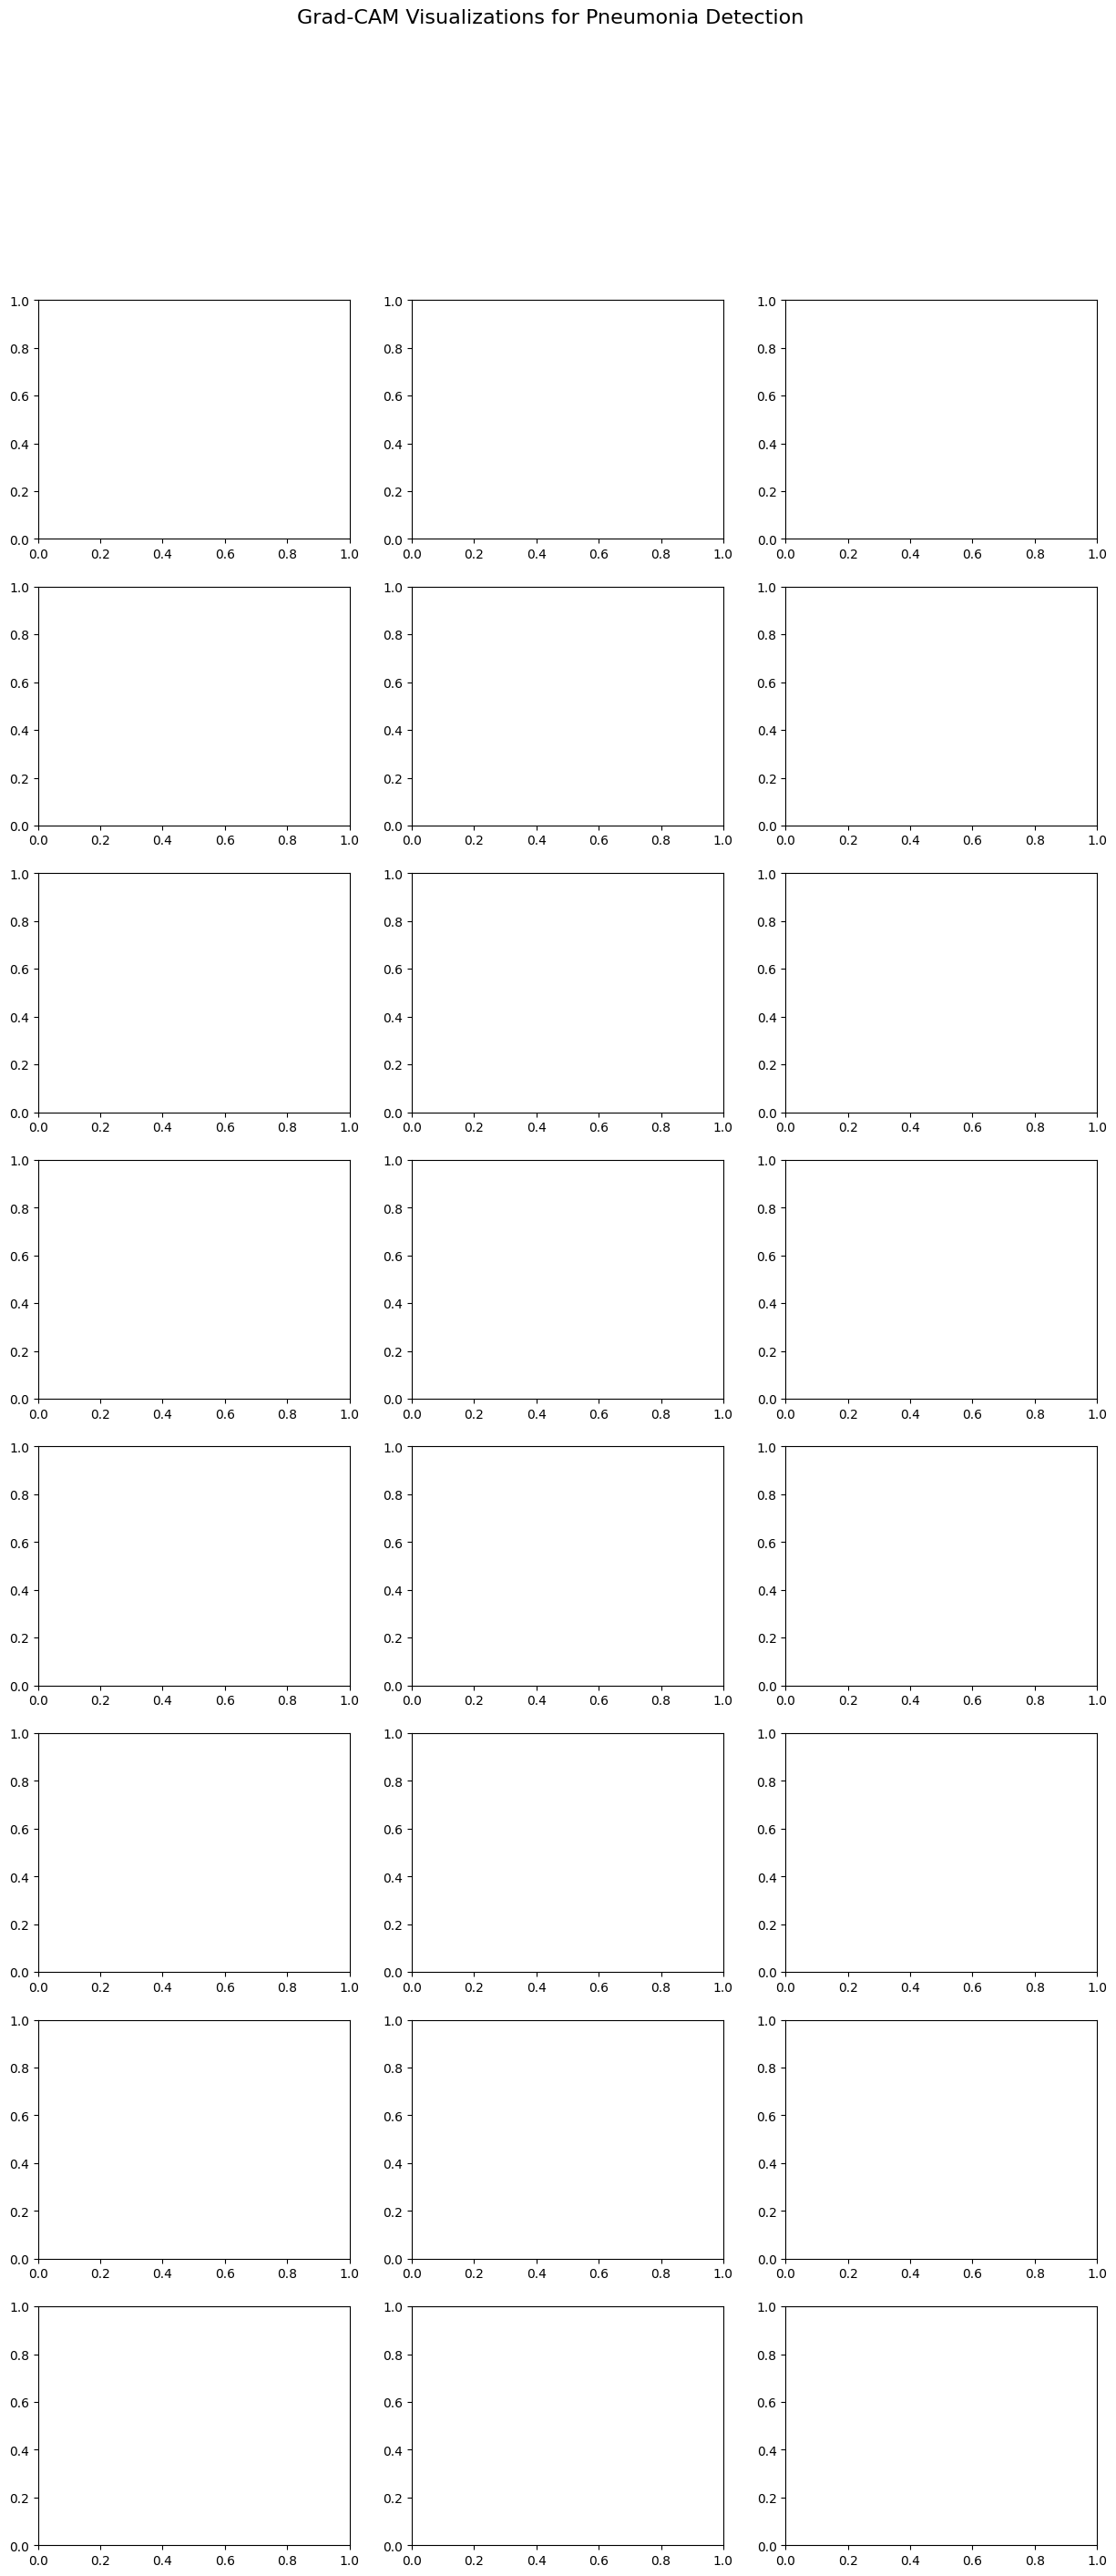

In [74]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models, optimizers
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
import cv2

# Base directory dataset (pastikan struktur direktori sesuai dataset Pneumonia)
base_dir = "/kaggle/input/pneumonia"
train_dir = os.path.join(base_dir, "Pneumonia/train")
val_dir = os.path.join(base_dir, "Pneumonia/val")
test_dir = os.path.join(base_dir, "Pneumonia/test")

# Verifikasi direktori
for d in [train_dir, val_dir, test_dir]:
    if not os.path.exists(d):
        raise FileNotFoundError(f"Directory not found: {d}")

# ============================
# Data Preparation & Augmentasi
# ============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# ============================
# Class Weights (imbalance)
# ============================
classes = np.unique(train_gen.classes)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_gen.classes)
class_weights = dict(enumerate(class_weights))

# ============================
# Model: EfficientNetB0
# ============================
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Bekukan bobot pretrained

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Keluaran sigmoid untuk klasifikasi biner
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ============================
# Callbacks: EarlyStopping & ReduceLROnPlateau
# ============================
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# ============================
# Training awal dengan Frozen Base
# ============================
print("Starting initial training with frozen base model...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# ============================
# Fine-Tuning: buka kembali base_model
# ============================
print("Starting fine-tuning phase...")
base_model.trainable = True
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# ============================
# Evaluasi pada Test Set
# ============================
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

y_true = test_gen.classes
y_pred_probs = model.predict(test_gen, verbose=0)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
target_names = list(test_gen.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# ROC AUC Score
roc_auc = roc_auc_score(y_true, y_pred_probs)
print(f"AUROC: {roc_auc:.2f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_true, y_pred_probs)
plt.title("ROC Curve")
plt.show()

# Plot Training History
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc (phase 1)', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Acc (phase 1)', color='red')
plt.plot(range(len(history.history['accuracy']), len(history.history['accuracy']) + len(history_fine.history['accuracy'])), 
         history_fine.history['accuracy'], label='Train Acc (phase 2)', color='blue', linestyle='--')
plt.plot(range(len(history.history['val_accuracy']), len(history.history['val_accuracy']) + len(history_fine.history['val_accuracy'])), 
         history_fine.history['val_accuracy'], label='Val Acc (phase 2)', color='red', linestyle='--')
plt.title("Akurasi Training dan Validasi")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss (phase 1)', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss (phase 1)', color='red')
plt.plot(range(len(history.history['loss']), len(history.history['loss']) + len(history_fine.history['loss'])), 
         history_fine.history['loss'], label='Train Loss (phase 2)', color='blue', linestyle='--')
plt.plot(range(len(history.history['val_loss']), len(history.history['val_loss']) + len(history_fine.history['val_loss'])), 
         history_fine.history['val_loss'], label='Val Loss (phase 2)', color='red', linestyle='--')
plt.title("Loss Training dan Validasi")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================
# Fungsi Grad-CAM yang Diperbaiki
# ============================
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Membuat heatmap Grad-CAM untuk visualisasi
    """
    # Akses base model (EfficientNetB0) dari Sequential model
    base_model = model.layers[0]  # EfficientNetB0 adalah layer pertama
    
    # Model untuk mendapatkan output konvolusi dan prediksi
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [base_model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Menghitung gradien
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, 0]  # untuk binary classification
    
    # Gradien output kelas terhadap peta fitur konvolusi terakhir
    grads = tape.gradient(class_channel, conv_outputs)
    
    # Pooling gradien secara spatial
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Mengalikan setiap channel dengan bobotnya
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalisasi heatmap ke rentang [0, 1]
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    """
    Menampilkan gambar dengan overlay heatmap Grad-CAM
    """
    # Load gambar asli
    img = load_img(img_path)
    img = img_to_array(img)
    
    # Resize heatmap ke ukuran gambar asli
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    
    # Terapkan colormap
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Superimpose heatmap pada gambar asli
    superimposed = heatmap_colored * alpha + img * (1 - alpha)
    superimposed = np.clip(superimposed, 0, 255).astype(np.uint8)
    
    return img.astype(np.uint8), heatmap_colored, superimposed

# ============================
# Menampilkan Grad-CAM untuk Beberapa Contoh Test
# ============================
print("\n" + "="*50)
print("GENERATING GRAD-CAM VISUALIZATIONS")
print("="*50)

# Mendapatkan layer konvolusi terakhir dari EfficientNetB0
# Akses base model dari Sequential model
base_model_for_layer = model.layers[0]  # EfficientNetB0

print("Available layers in base model:")
for layer in base_model_for_layer.layers:
    print(f"- {layer.name}")

# Cari layer konvolusi terakhir
last_conv_layer_name = None
for layer in base_model_for_layer.layers[::-1]:
    if hasattr(layer, 'activation') and 'conv' in layer.name.lower():
        last_conv_layer_name = layer.name
        break

# Jika tidak ditemukan, gunakan layer terakhir yang mengandung 'conv'
if last_conv_layer_name is None:
    for layer in base_model_for_layer.layers[::-1]:
        if 'conv' in layer.name.lower():
            last_conv_layer_name = layer.name
            break

# Fallback terakhir untuk EfficientNetB0
if last_conv_layer_name is None:
    last_conv_layer_name = "top_conv"

print(f"Using last conv layer: {last_conv_layer_name}")

# Verifikasi layer ada
try:
    test_layer = base_model_for_layer.get_layer(last_conv_layer_name)
    print(f"Layer found: {test_layer.name} with output shape: {test_layer.output.shape}")
except:
    print("Layer not found, trying alternative layers...")
    # Coba beberapa nama layer alternatif untuk EfficientNetB0
    alternative_layers = ["top_conv", "conv_head", "head_conv", "final_conv"]
    for alt_name in alternative_layers:
        try:
            test_layer = base_model_for_layer.get_layer(alt_name)
            last_conv_layer_name = alt_name
            print(f"Using alternative layer: {last_conv_layer_name}")
            break
        except:
            continue
    else:
        # Jika masih tidak ditemukan, gunakan layer terakhir yang memiliki 4D output
        for layer in base_model_for_layer.layers[::-1]:
            if len(layer.output.shape) == 4:  # 4D tensor (batch, height, width, channels)
                last_conv_layer_name = layer.name
                print(f"Using last 4D layer: {last_conv_layer_name}")
                break

# Reset test generator untuk mendapatkan file names
test_gen.reset()
filenames = test_gen.filenames
class_labels = list(test_gen.class_indices.keys())

# Pilih beberapa gambar untuk visualisasi (campuran dari kedua kelas)
num_samples = 8
selected_indices = []

# Ambil beberapa sampel dari masing-masing kelas
normal_count = 0
pneumonia_count = 0

for i, fname in enumerate(filenames):
    if normal_count >= num_samples//2 and pneumonia_count >= num_samples//2:
        break
    
    true_class = class_labels[y_true[i]]
    
    if true_class == 'NORMAL' and normal_count < num_samples//2:
        selected_indices.append(i)
        normal_count += 1
    elif true_class == 'PNEUMONIA' and pneumonia_count < num_samples//2:
        selected_indices.append(i)
        pneumonia_count += 1

# Visualisasi Grad-CAM
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4*num_samples))
fig.suptitle('Grad-CAM Visualizations for Pneumonia Detection', fontsize=16, y=0.98)

for idx, sample_idx in enumerate(selected_indices):
    fname = filenames[sample_idx]
    img_path = os.path.join(test_dir, fname)
    
    # Load dan preprocess gambar
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    
    # Prediksi
    prediction = model.predict(x, verbose=0)[0][0]
    predicted_class = 'PNEUMONIA' if prediction > 0.5 else 'NORMAL'
    true_class = class_labels[y_true[sample_idx]]
    
    # Generate heatmap
    heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name)
    
    # Display hasil
    original_img, heatmap_colored, superimposed = display_gradcam(img_path, heatmap)
    
    # Plot gambar asli
    axes[idx, 0].imshow(original_img)
    axes[idx, 0].set_title(f'Original\nTrue: {true_class}\nPred: {predicted_class} ({prediction:.3f})', fontsize=10)
    axes[idx, 0].axis('off')
    
    # Plot heatmap
    axes[idx, 1].imshow(heatmap_colored)
    axes[idx, 1].set_title('Grad-CAM\nHeatmap', fontsize=10)
    axes[idx, 1].axis('off')
    
    # Plot superimposed
    axes[idx, 2].imshow(superimposed)
    axes[idx, 2].set_title('Superimposed\nVisualization', fontsize=10)
    axes[idx, 2].axis('off')
    
    # Tambahkan border hijau untuk prediksi benar, merah untuk salah
    border_color = 'green' if predicted_class == true_class else 'red'
    for ax in axes[idx, :]:
        for spine in ax.spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(2)

plt.tight_layout()
plt.show()

# ============================
# Analisis Statistik Grad-CAM
# ============================
print("\n" + "="*50)
print("GRAD-CAM ANALYSIS SUMMARY")
print("="*50)

# Hitung statistik untuk semua gambar test
all_heatmaps = []
correct_predictions = 0

for i in range(min(50, len(filenames))):  # Analisis 50 gambar pertama
    fname = filenames[i]
    img_path = os.path.join(test_dir, fname)
    
    # Load dan preprocess gambar
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    
    # Prediksi
    prediction = model.predict(x, verbose=0)[0][0]
    predicted_class = 'PNEUMONIA' if prediction > 0.5 else 'NORMAL'
    true_class = class_labels[y_true[i]]
    
    if predicted_class == true_class:
        correct_predictions += 1
    
    # Generate heatmap
    heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name)
    all_heatmaps.append(heatmap)

print(f"Accuracy on analyzed samples: {correct_predictions}/{min(50, len(filenames))} = {correct_predictions/min(50, len(filenames))*100:.1f}%")
print(f"Average heatmap activation: {np.mean([np.mean(h) for h in all_heatmaps]):.3f}")
print(f"Max heatmap activation: {np.max([np.max(h) for h in all_heatmaps]):.3f}")

print("\n" + "="*50)
print("GRAD-CAM VISUALIZATION COMPLETED!")
print("="*50)

2025-07-08 21:07:10.121405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752008830.326468      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752008830.384516      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


I0000 00:00:1752008851.255903      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752008851.256699      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Starting initial training with frozen base model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1752008871.837034     125 service.cc:148] XLA service 0x7af44c013e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752008871.837657     125 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752008871.837676     125 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752008873.791997     125 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/163 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.4062 - loss: 0.7314    

I0000 00:00:1752008883.687126     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 170s 879ms/step - accuracy: 0.4945 - loss: 0.7131 - val_accuracy: 0.5000 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 564ms/step - accuracy: 0.5020 - loss: 0.6955 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 564ms/step - accuracy: 0.3130 - loss: 0.6913 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 566ms/step - accuracy: 0.3485 - loss: 0.7009 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 563ms/step - accuracy: 0.5293 - loss: 0.6998 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 2.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 566ms/step - accuracy: 0.6608 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 2.0000e-04
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 565ms/step - accuracy: 0.751

E0000 00:00:1752009740.109567     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752009740.253015     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752009740.719118     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752009740.860549     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752009741.000012     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


163/163 ━━━━━━━━━━━━━━━━━━━━ 192s 626ms/step - accuracy: 0.7643 - loss: 0.4293 - val_accuracy: 0.5000 - val_loss: 0.6975 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 578ms/step - accuracy: 0.9463 - loss: 0.1406 - val_accuracy: 0.5625 - val_loss: 0.6198 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 575ms/step - accuracy: 0.9537 - loss: 0.1079 - val_accuracy: 0.5000 - val_loss: 0.9832 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 574ms/step - accuracy: 0.9648 - loss: 0.0960 - val_accuracy: 0.5000 - val_loss: 1.5961 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 578ms/step - accuracy: 0.9682 - loss: 0.0773 - val_accuracy: 0.5000 - val_loss: 1402.3542 - learning_rate: 1.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 574ms/step - accuracy: 0.9681 - loss: 0.0901 - val_accuracy: 0.6875 - val_loss: 0.5070 - learning_rate: 2.0000e-05
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 572ms/ste

<Figure size 800x600 with 0 Axes>

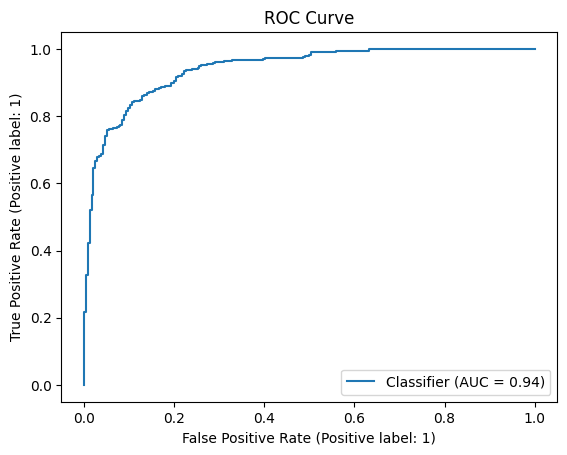

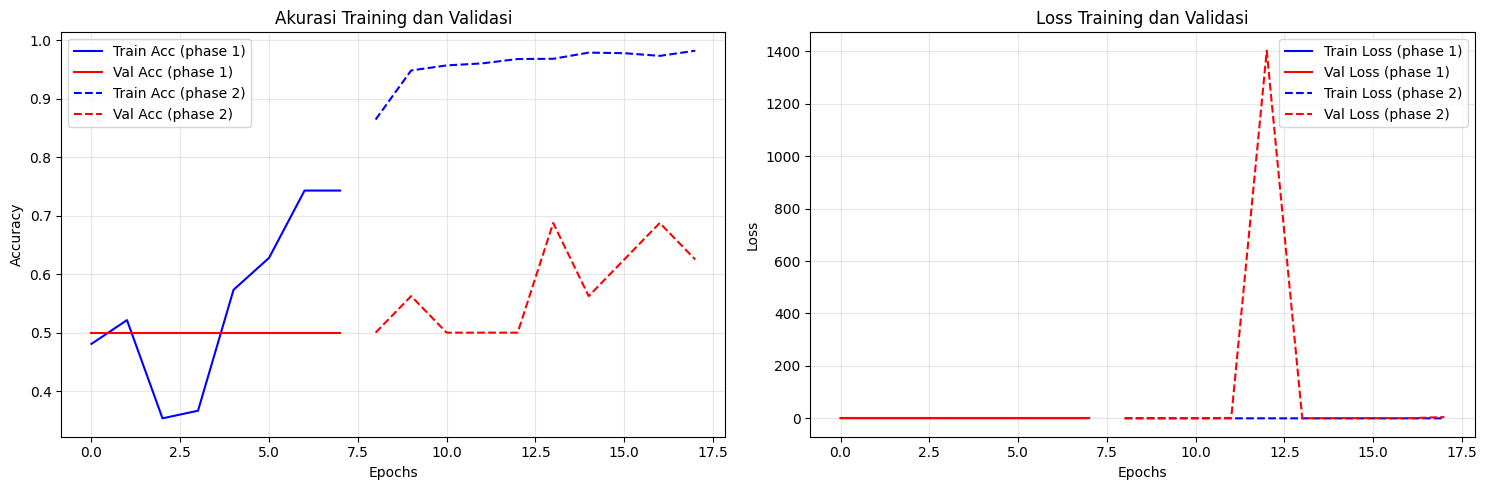


GENERATING GRAD-CAM VISUALIZATIONS
Using last conv layer: top_conv
Layer found: top_conv
Layer output shape: (None, 7, 7, 1280)
Error processing sample 1: The layer sequential has never been called and thus has no defined input.
Error processing sample 2: The layer sequential has never been called and thus has no defined input.
Error processing sample 3: The layer sequential has never been called and thus has no defined input.
Error processing sample 4: The layer sequential has never been called and thus has no defined input.
Error processing sample 5: The layer sequential has never been called and thus has no defined input.
Error processing sample 6: The layer sequential has never been called and thus has no defined input.
Error processing sample 7: The layer sequential has never been called and thus has no defined input.
Error processing sample 8: The layer sequential has never been called and thus has no defined input.


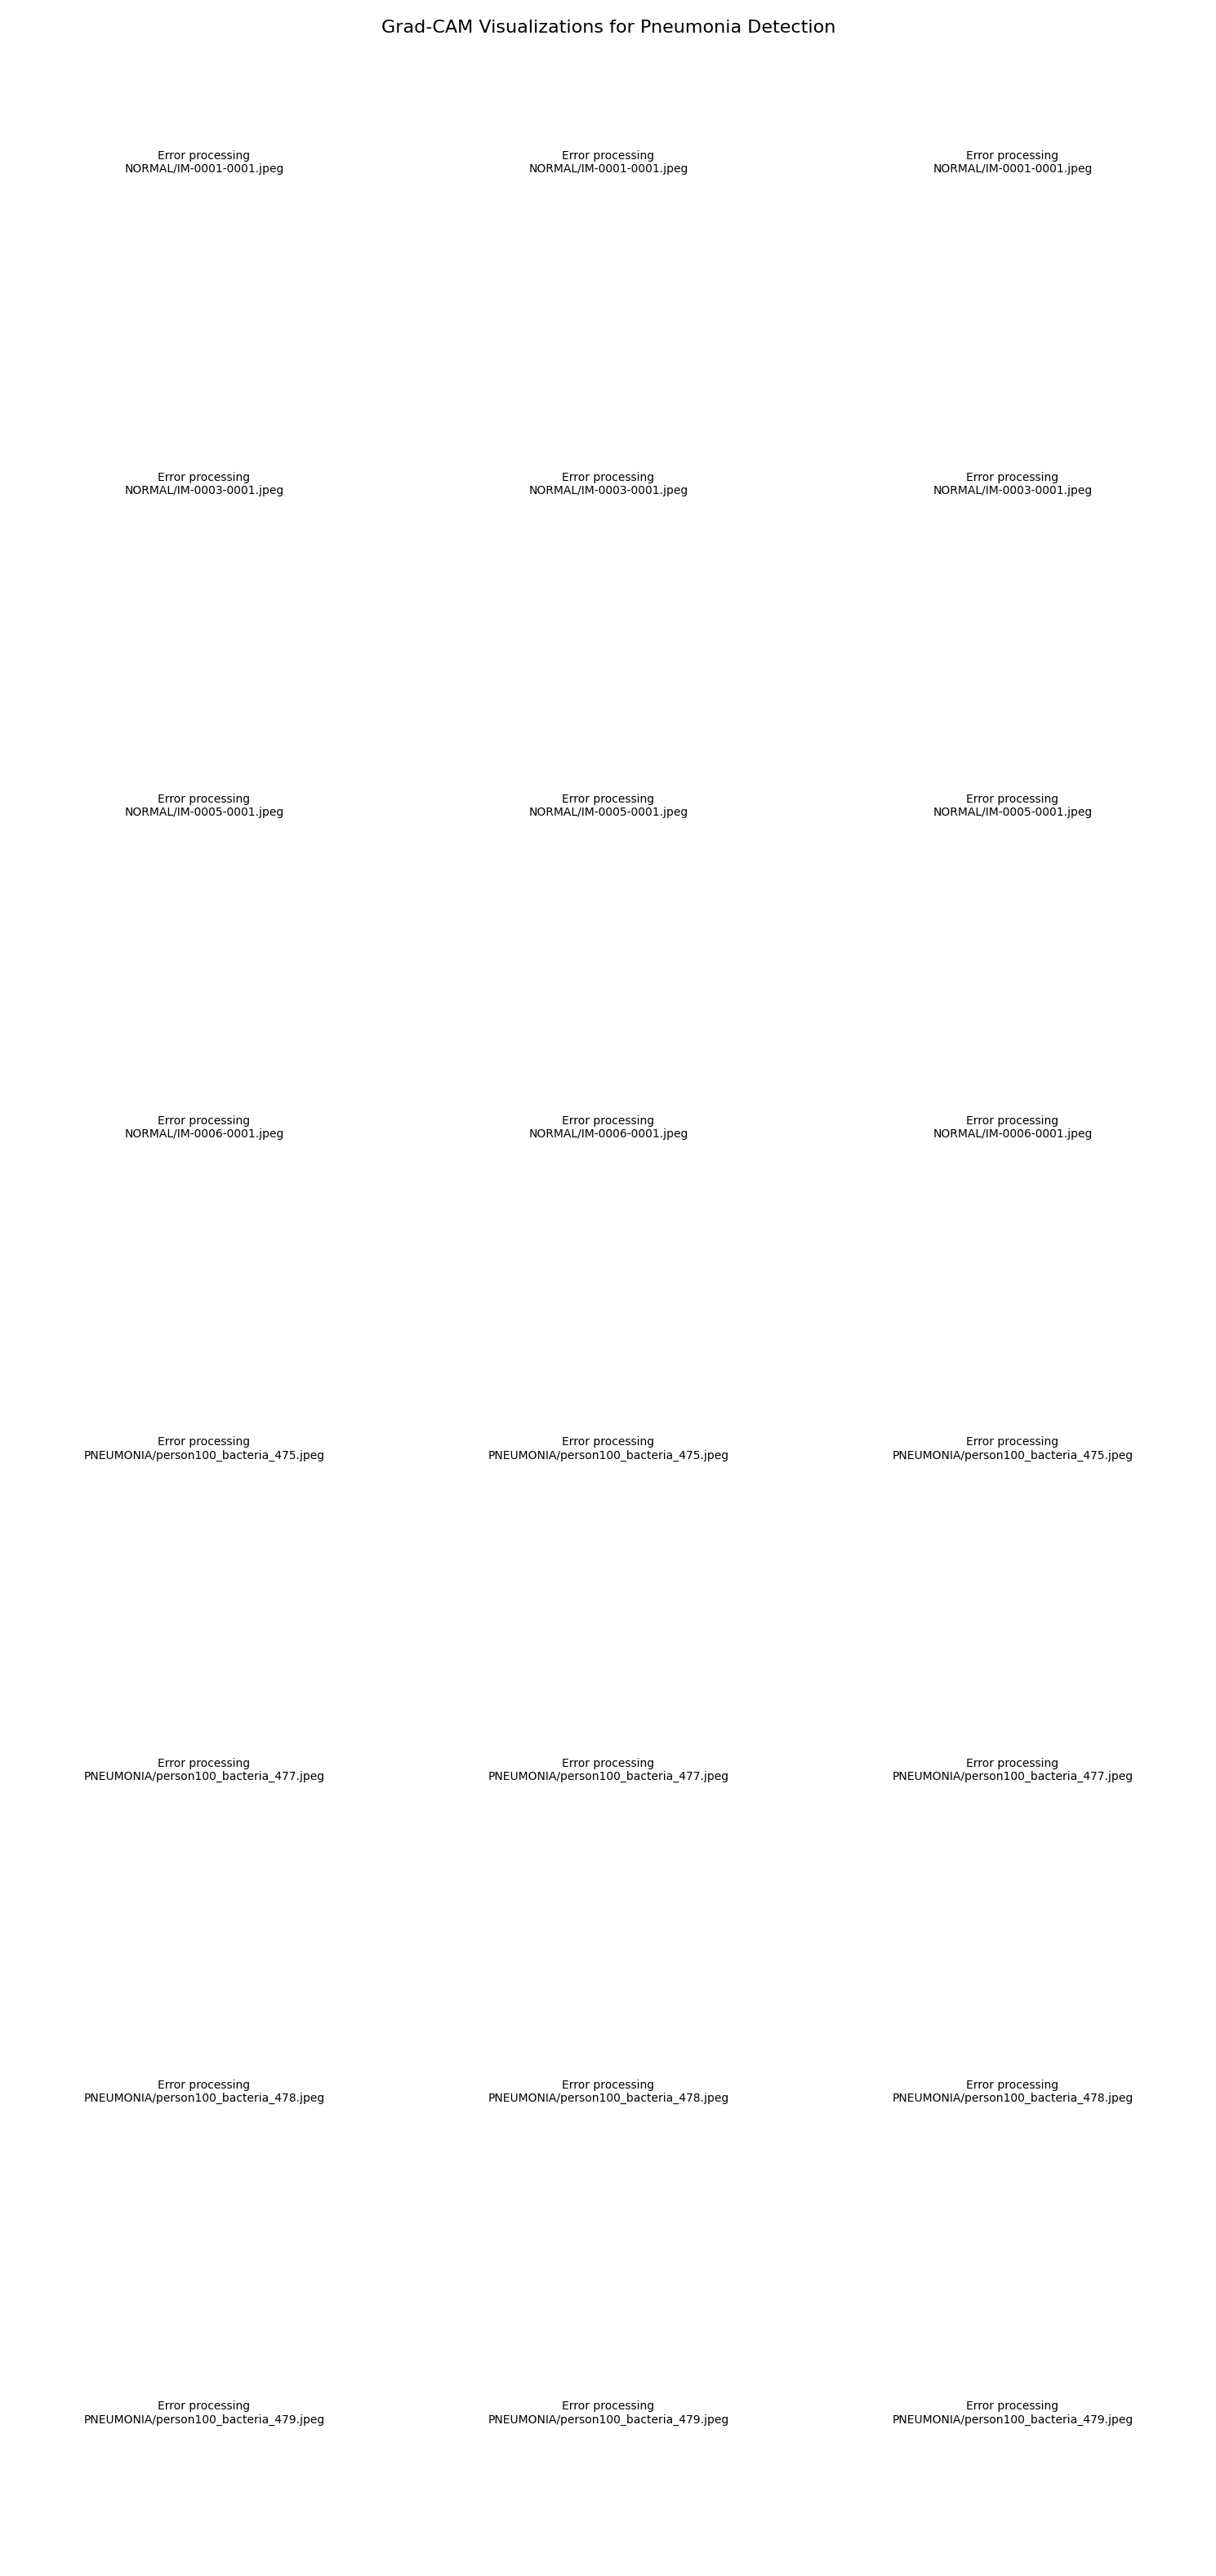


GRAD-CAM ANALYSIS SUMMARY
Error processing sample 1: The layer sequential has never been called and thus has no defined input.
Error processing sample 2: The layer sequential has never been called and thus has no defined input.
Error processing sample 3: The layer sequential has never been called and thus has no defined input.
Error processing sample 4: The layer sequential has never been called and thus has no defined input.
Error processing sample 5: The layer sequential has never been called and thus has no defined input.
Error processing sample 6: The layer sequential has never been called and thus has no defined input.
Error processing sample 7: The layer sequential has never been called and thus has no defined input.
Error processing sample 8: The layer sequential has never been called and thus has no defined input.
Error processing sample 9: The layer sequential has never been called and thus has no defined input.
Error processing sample 10: The layer sequential has never been 

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models, optimizers
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
import cv2

# Base directory dataset (pastikan struktur direktori sesuai dataset Pneumonia)
base_dir = "/kaggle/input/pneumonia"
train_dir = os.path.join(base_dir, "Pneumonia/train")
val_dir = os.path.join(base_dir, "Pneumonia/val")
test_dir = os.path.join(base_dir, "Pneumonia/test")

# Verifikasi direktori
for d in [train_dir, val_dir, test_dir]:
    if not os.path.exists(d):
        raise FileNotFoundError(f"Directory not found: {d}")

# ============================
# Data Preparation & Augmentasi
# ============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# ============================
# Class Weights (imbalance)
# ============================
classes = np.unique(train_gen.classes)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_gen.classes)
class_weights = dict(enumerate(class_weights))

# ============================
# Model: EfficientNetB0
# ============================
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Bekukan bobot pretrained

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Keluaran sigmoid untuk klasifikasi biner
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ============================
# Callbacks: EarlyStopping & ReduceLROnPlateau
# ============================
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# ============================
# Training awal dengan Frozen Base
# ============================
print("Starting initial training with frozen base model...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# ============================
# Fine-Tuning: buka kembali base_model
# ============================
print("Starting fine-tuning phase...")
base_model.trainable = True
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# ============================
# Evaluasi pada Test Set
# ============================
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

y_true = test_gen.classes
y_pred_probs = model.predict(test_gen, verbose=0)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
target_names = list(test_gen.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# ROC AUC Score
roc_auc = roc_auc_score(y_true, y_pred_probs)
print(f"AUROC: {roc_auc:.2f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_true, y_pred_probs)
plt.title("ROC Curve")
plt.show()

# Plot Training History
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc (phase 1)', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Acc (phase 1)', color='red')
plt.plot(range(len(history.history['accuracy']), len(history.history['accuracy']) + len(history_fine.history['accuracy'])), 
         history_fine.history['accuracy'], label='Train Acc (phase 2)', color='blue', linestyle='--')
plt.plot(range(len(history.history['val_accuracy']), len(history.history['val_accuracy']) + len(history_fine.history['val_accuracy'])), 
         history_fine.history['val_accuracy'], label='Val Acc (phase 2)', color='red', linestyle='--')
plt.title("Akurasi Training dan Validasi")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss (phase 1)', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss (phase 1)', color='red')
plt.plot(range(len(history.history['loss']), len(history.history['loss']) + len(history_fine.history['loss'])), 
         history_fine.history['loss'], label='Train Loss (phase 2)', color='blue', linestyle='--')
plt.plot(range(len(history.history['val_loss']), len(history.history['val_loss']) + len(history_fine.history['val_loss'])), 
         history_fine.history['val_loss'], label='Val Loss (phase 2)', color='red', linestyle='--')
plt.title("Loss Training dan Validasi")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================
# Fungsi Grad-CAM yang Diperbaiki
# ============================
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Membuat heatmap Grad-CAM untuk visualisasi
    """
    # Akses base model (EfficientNetB0) dari Sequential model
    base_model = model.layers[0]  # EfficientNetB0 adalah layer pertama
    
    # Buat model baru untuk Grad-CAM dengan input yang sama
    # tapi output dari layer konvolusi terakhir dan prediksi final
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[base_model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Menghitung gradien
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, 0]  # untuk binary classification
    
    # Gradien output kelas terhadap peta fitur konvolusi terakhir
    grads = tape.gradient(class_channel, conv_outputs)
    
    # Pooling gradien secara spatial
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Mengalikan setiap channel dengan bobotnya
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalisasi heatmap ke rentang [0, 1]
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    """
    Menampilkan gambar dengan overlay heatmap Grad-CAM
    """
    # Load gambar asli
    img = load_img(img_path)
    img = img_to_array(img)
    
    # Resize heatmap ke ukuran gambar asli
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    
    # Terapkan colormap
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Superimpose heatmap pada gambar asli
    superimposed = heatmap_colored * alpha + img * (1 - alpha)
    superimposed = np.clip(superimposed, 0, 255).astype(np.uint8)
    
    return img.astype(np.uint8), heatmap_colored, superimposed


# ============================
# Menampilkan Grad-CAM untuk Beberapa Contoh Test
# ============================
print("\n" + "="*50)
print("GENERATING GRAD-CAM VISUALIZATIONS")
print("="*50)

# Mendapatkan layer konvolusi terakhir dari EfficientNetB0
# Akses base model dari Sequential model
base_model_for_layer = model.layers[0]  # EfficientNetB0

# Untuk EfficientNetB0, layer konvolusi terakhir adalah 'top_conv'
last_conv_layer_name = "top_conv"

print(f"Using last conv layer: {last_conv_layer_name}")

# Verifikasi layer ada
try:
    test_layer = base_model_for_layer.get_layer(last_conv_layer_name)
    print(f"Layer found: {test_layer.name}")
    print(f"Layer output shape: {test_layer.output.shape}")
except Exception as e:
    print(f"Error accessing layer: {e}")
    # Fallback ke layer alternatif
    for layer in base_model_for_layer.layers[::-1]:
        if 'conv' in layer.name.lower() and len(layer.output.shape) == 4:
            last_conv_layer_name = layer.name
            print(f"Using fallback layer: {last_conv_layer_name}")
            print(f"Fallback layer output shape: {layer.output.shape}")
            break

# Reset test generator untuk mendapatkan file names
test_gen.reset()
filenames = test_gen.filenames
class_labels = list(test_gen.class_indices.keys())

# Pilih beberapa gambar untuk visualisasi (campuran dari kedua kelas)
num_samples = 8
selected_indices = []

# Ambil beberapa sampel dari masing-masing kelas
normal_count = 0
pneumonia_count = 0

for i, fname in enumerate(filenames):
    if normal_count >= num_samples//2 and pneumonia_count >= num_samples//2:
        break
    
    true_class = class_labels[y_true[i]]
    
    if true_class == 'NORMAL' and normal_count < num_samples//2:
        selected_indices.append(i)
        normal_count += 1
    elif true_class == 'PNEUMONIA' and pneumonia_count < num_samples//2:
        selected_indices.append(i)
        pneumonia_count += 1

# Visualisasi Grad-CAM
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4*num_samples))
if num_samples == 1:
    axes = axes.reshape(1, -1)
fig.suptitle('Grad-CAM Visualizations for Pneumonia Detection', fontsize=16, y=0.98)

for idx, sample_idx in enumerate(selected_indices):
    fname = filenames[sample_idx]
    img_path = os.path.join(test_dir, fname)
    
    try:
        # Load dan preprocess gambar
        img = load_img(img_path, target_size=(224, 224))
        x = img_to_array(img) / 255.0
        x = np.expand_dims(x, axis=0)
        
        # Prediksi
        prediction = model.predict(x, verbose=0)[0][0]
        predicted_class = 'PNEUMONIA' if prediction > 0.5 else 'NORMAL'
        true_class = class_labels[y_true[sample_idx]]
        
        # Generate heatmap
        heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name)
        
        # Display hasil
        original_img, heatmap_colored, superimposed = display_gradcam(img_path, heatmap)
        
        # Plot gambar asli
        axes[idx, 0].imshow(original_img)
        axes[idx, 0].set_title(f'Original\nTrue: {true_class}\nPred: {predicted_class} ({prediction:.3f})', fontsize=10)
        axes[idx, 0].axis('off')
        
        # Plot heatmap
        axes[idx, 1].imshow(heatmap_colored)
        axes[idx, 1].set_title('Grad-CAM\nHeatmap', fontsize=10)
        axes[idx, 1].axis('off')
        
        # Plot superimposed
        axes[idx, 2].imshow(superimposed)
        axes[idx, 2].set_title('Superimposed\nVisualization', fontsize=10)
        axes[idx, 2].axis('off')
        
        # Tambahkan border hijau untuk prediksi benar, merah untuk salah
        border_color = 'green' if predicted_class == true_class else 'red'
        for ax in axes[idx, :]:
            for spine in ax.spines.values():
                spine.set_edgecolor(border_color)
                spine.set_linewidth(2)
                
        print(f"Processed sample {idx+1}/{num_samples}: {fname}")
        
    except Exception as e:
        print(f"Error processing sample {idx+1}: {e}")
        # Tampilkan placeholder jika ada error
        for j in range(3):
            axes[idx, j].text(0.5, 0.5, f'Error processing\n{fname}', 
                            ha='center', va='center', transform=axes[idx, j].transAxes)
            axes[idx, j].axis('off')

plt.tight_layout()
plt.show()

# ============================
# Analisis Statistik Grad-CAM
# ============================
print("\n" + "="*50)
print("GRAD-CAM ANALYSIS SUMMARY")
print("="*50)

# Hitung statistik untuk semua gambar test
all_heatmaps = []
correct_predictions = 0

for i in range(min(20, len(filenames))):  # Analisis 20 gambar pertama untuk menghindari timeout
    try:
        fname = filenames[i]
        img_path = os.path.join(test_dir, fname)
        
        # Load dan preprocess gambar
        img = load_img(img_path, target_size=(224, 224))
        x = img_to_array(img) / 255.0
        x = np.expand_dims(x, axis=0)
        
        # Prediksi
        prediction = model.predict(x, verbose=0)[0][0]
        predicted_class = 'PNEUMONIA' if prediction > 0.5 else 'NORMAL'
        true_class = class_labels[y_true[i]]
        
        if predicted_class == true_class:
            correct_predictions += 1
        
        # Generate heatmap
        heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name)
        all_heatmaps.append(heatmap)
        
    except Exception as e:
        print(f"Error processing sample {i+1}: {e}")
        continue

if all_heatmaps:
    analyzed_samples = len(all_heatmaps)
    print(f"Successfully analyzed: {analyzed_samples} samples")
    print(f"Accuracy on analyzed samples: {correct_predictions}/{analyzed_samples} = {correct_predictions/analyzed_samples*100:.1f}%")
    print(f"Average heatmap activation: {np.mean([np.mean(h) for h in all_heatmaps]):.3f}")
    print(f"Max heatmap activation: {np.max([np.max(h) for h in all_heatmaps]):.3f}")
else:
    print("No samples could be analyzed successfully")

print("\n" + "="*50)
print("GRAD-CAM VISUALIZATION COMPLETED!")
print("="*50)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Starting initial training with frozen base model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 134s 659ms/step - accuracy: 0.5523 - loss: 0.7007 - val_accuracy: 0.5000 - val_loss: 0.6943 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 616ms/step - accuracy: 0.4087 - loss: 0.6978 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 621ms/step - accuracy: 0.7463 - loss: 0.6854 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 615ms/step - accuracy: 0.5193 - loss: 0.6891 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 615ms/step - accuracy: 0.4675 - loss: 0.6881 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 616ms/step - accuracy: 0.2553 - loss: 0.6914 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 2.0000e-04
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 615ms/step - ac

<Figure size 800x600 with 0 Axes>

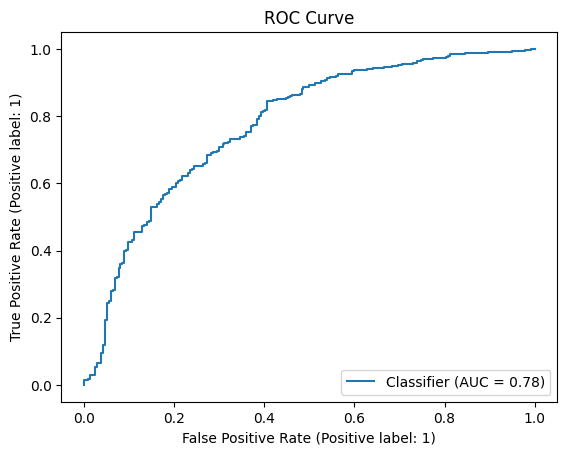

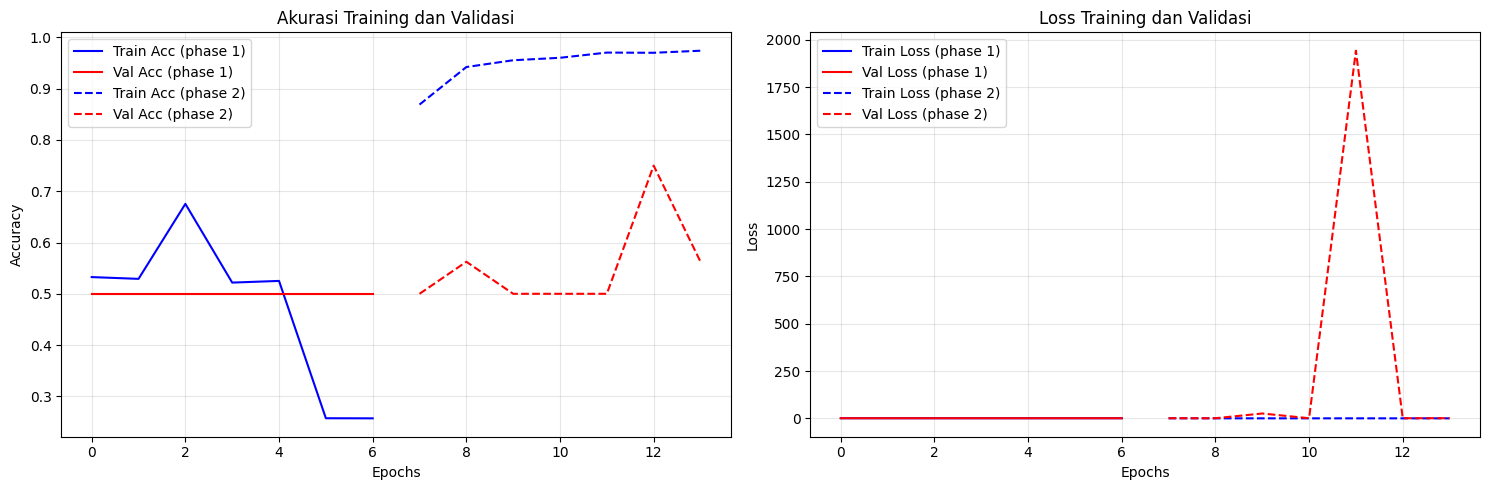


GENERATING GRAD-CAM VISUALIZATIONS
Ensuring model is properly built...
✓ Model built explicitly
✓ Dummy prediction successful
✓ Model recompiled
Using last conv layer: top_conv
✓ Layer found: top_conv
✓ Layer output shape: (None, 7, 7, 1280)
Found 624 test images
Class labels: ['NORMAL', 'PNEUMONIA']
Selected 8 samples for visualization
Alternative method failed: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.
Fallback: Creating new input for Grad-CAM model
Both methods failed: 'Exception encountered when calling Functional.call().\n\n\x1b135244616071248\x1b\n\nArguments received by Functional.call():\n  • inputs=array([[[[0.1254902 , 0.1254902 , 0.1254902 ],\n         [0.12156863, 0.12156863, 0.12156863],\n         [0.1254902 , 0.1254902 , 0.1254902 ],\n         ...,\n         [0.1254902 , 0.1254902 , 0.1254902 ],\n         [0.11764706, 0.11764706, 0.11764706],\n         [0.13725491, 0.13725491, 0.13725491]],\n\n        [[0.13333334, 0.133

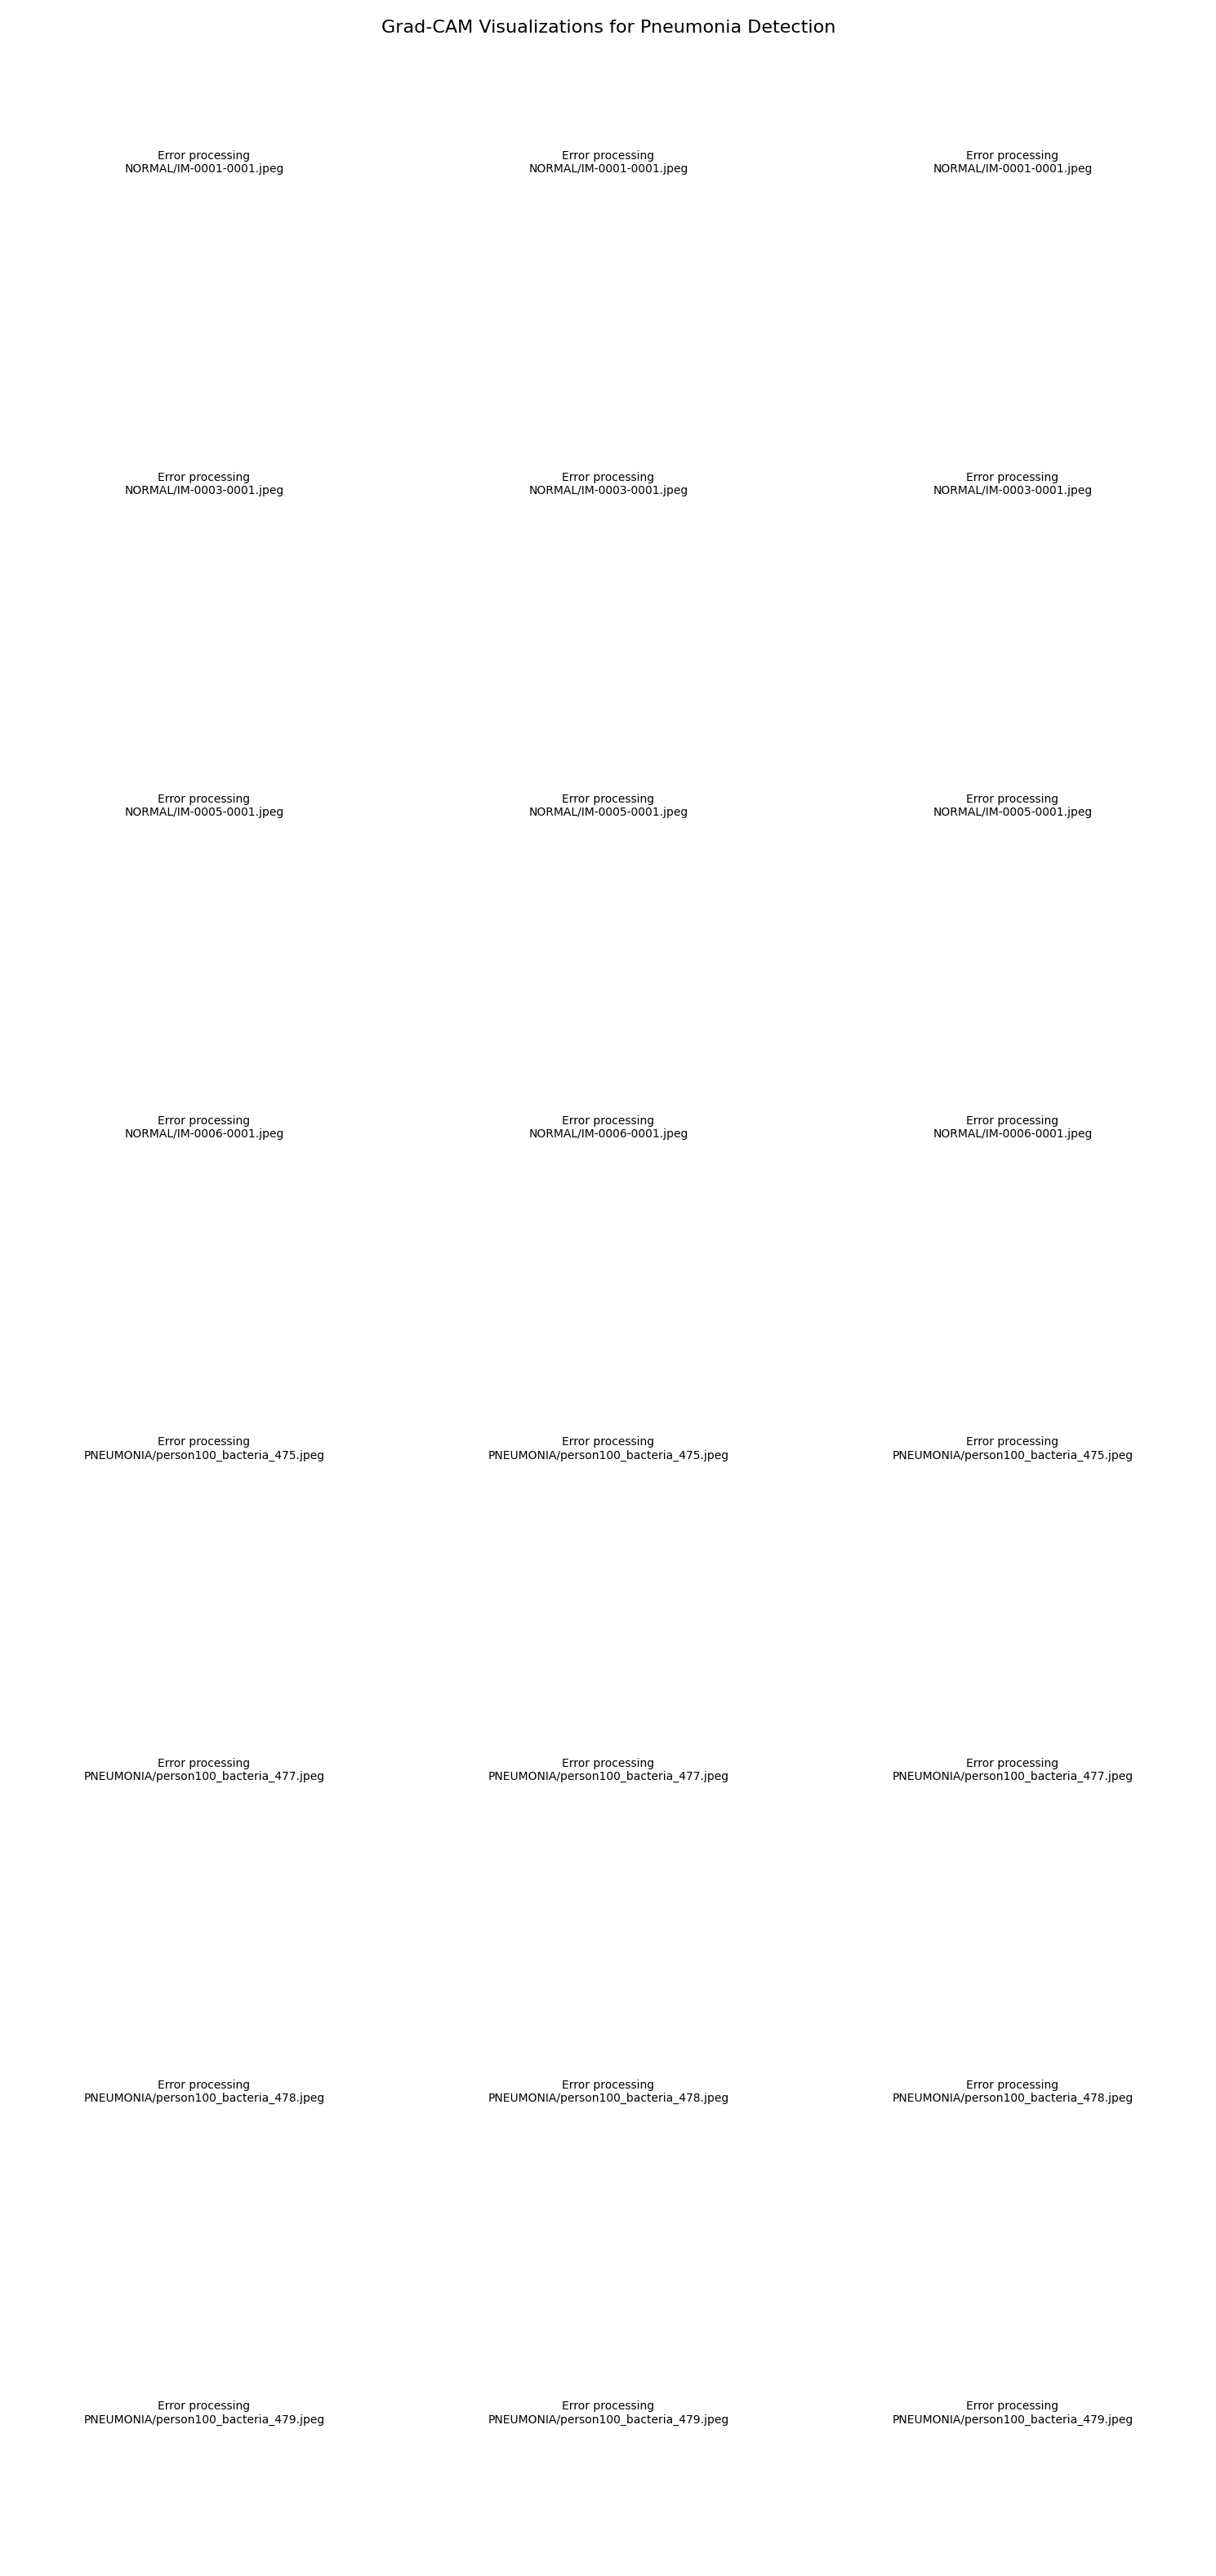


GRAD-CAM ANALYSIS SUMMARY
Error processing sample 1: 'Exception encountered when calling Functional.call().\n\n\x1b135244616071248\x1b\n\nArguments received by Functional.call():\n  • inputs=array([[[[0.1254902 , 0.1254902 , 0.1254902 ],\n         [0.12156863, 0.12156863, 0.12156863],\n         [0.1254902 , 0.1254902 , 0.1254902 ],\n         ...,\n         [0.1254902 , 0.1254902 , 0.1254902 ],\n         [0.11764706, 0.11764706, 0.11764706],\n         [0.13725491, 0.13725491, 0.13725491]],\n\n        [[0.13333334, 0.13333334, 0.13333334],\n         [0.12941177, 0.12941177, 0.12941177],\n         [0.11764706, 0.11764706, 0.11764706],\n         ...,\n         [0.11764706, 0.11764706, 0.11764706],\n         [0.12941177, 0.12941177, 0.12941177],\n         [0.12941177, 0.12941177, 0.12941177]],\n\n        [[0.12941177, 0.12941177, 0.12941177],\n         [0.1254902 , 0.1254902 , 0.1254902 ],\n         [0.12941177, 0.12941177, 0.12941177],\n         ...,\n         [0.1254902 , 0.1254902 , 0.1

In [13]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models, optimizers
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
import cv2

# Base directory dataset (pastikan struktur direktori sesuai dataset Pneumonia)
base_dir = "/kaggle/input/pneumonia"
train_dir = os.path.join(base_dir, "Pneumonia/train")
val_dir = os.path.join(base_dir, "Pneumonia/val")
test_dir = os.path.join(base_dir, "Pneumonia/test")

# Verifikasi direktori
for d in [train_dir, val_dir, test_dir]:
    if not os.path.exists(d):
        raise FileNotFoundError(f"Directory not found: {d}")

# ============================
# Data Preparation & Augmentasi
# ============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# ============================
# Class Weights (imbalance)
# ============================
classes = np.unique(train_gen.classes)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_gen.classes)
class_weights = dict(enumerate(class_weights))

# ============================
# Model: EfficientNetB0
# ============================
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Bekukan bobot pretrained

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Keluaran sigmoid untuk klasifikasi biner
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ============================
# Callbacks: EarlyStopping & ReduceLROnPlateau
# ============================
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# ============================
# Training awal dengan Frozen Base
# ============================
print("Starting initial training with frozen base model...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# ============================
# Fine-Tuning: buka kembali base_model
# ============================
print("Starting fine-tuning phase...")
base_model.trainable = True
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# ============================
# Evaluasi pada Test Set
# ============================
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

y_true = test_gen.classes
y_pred_probs = model.predict(test_gen, verbose=0)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
target_names = list(test_gen.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# ROC AUC Score
roc_auc = roc_auc_score(y_true, y_pred_probs)
print(f"AUROC: {roc_auc:.2f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_true, y_pred_probs)
plt.title("ROC Curve")
plt.show()

# Plot Training History
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc (phase 1)', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Acc (phase 1)', color='red')
plt.plot(range(len(history.history['accuracy']), len(history.history['accuracy']) + len(history_fine.history['accuracy'])), 
         history_fine.history['accuracy'], label='Train Acc (phase 2)', color='blue', linestyle='--')
plt.plot(range(len(history.history['val_accuracy']), len(history.history['val_accuracy']) + len(history_fine.history['val_accuracy'])), 
         history_fine.history['val_accuracy'], label='Val Acc (phase 2)', color='red', linestyle='--')
plt.title("Akurasi Training dan Validasi")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss (phase 1)', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss (phase 1)', color='red')
plt.plot(range(len(history.history['loss']), len(history.history['loss']) + len(history_fine.history['loss'])), 
         history_fine.history['loss'], label='Train Loss (phase 2)', color='blue', linestyle='--')
plt.plot(range(len(history.history['val_loss']), len(history.history['val_loss']) + len(history_fine.history['val_loss'])), 
         history_fine.history['val_loss'], label='Val Loss (phase 2)', color='red', linestyle='--')
plt.title("Loss Training dan Validasi")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================
# Fungsi Grad-CAM yang Diperbaiki - Versi Robust
# ============================
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Membuat heatmap Grad-CAM untuk visualisasi - Versi yang lebih robust
    """
    # Pastikan model sudah dibangun
    if not hasattr(model, '_built') or not model._built:
        model.build(input_shape=(None, 224, 224, 3))
    
    # Akses base model (EfficientNetB0) dari Sequential model
    base_model = model.layers[0]  # EfficientNetB0 adalah layer pertama
    
    # Buat model baru untuk Grad-CAM dengan cara yang lebih eksplisit
    # Menggunakan input dari model yang sudah ada
    try:
        # Metode 1: Menggunakan input yang sudah ada
        model_input = model.input
        conv_output = base_model.get_layer(last_conv_layer_name).output
        model_output = model.output
        
        grad_model = tf.keras.Model(
            inputs=model_input,
            outputs=[conv_output, model_output]
        )
    except:
        # Metode 2: Buat input baru jika gagal
        print("Fallback: Creating new input for Grad-CAM model")
        new_input = tf.keras.Input(shape=(224, 224, 3))
        new_conv_output = base_model.get_layer(last_conv_layer_name).output
        new_model_output = model(new_input)
        
        grad_model = tf.keras.Model(
            inputs=new_input,
            outputs=[new_conv_output, new_model_output]
        )
    
    # Menghitung gradien
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, 0]  # untuk binary classification
    
    # Gradien output kelas terhadap peta fitur konvolusi terakhir
    grads = tape.gradient(class_channel, conv_outputs)
    
    # Pooling gradien secara spatial
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Mengalikan setiap channel dengan bobotnya
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalisasi heatmap ke rentang [0, 1]
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    
    return heatmap.numpy()

def make_gradcam_heatmap_alternative(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Alternatif Grad-CAM yang lebih sederhana dan robust
    """
    # Akses base model
    base_model = model.layers[0]
    
    # Buat fungsi untuk mendapatkan feature maps dan prediksi
    conv_layer = base_model.get_layer(last_conv_layer_name)
    
    # Buat model sementara untuk mendapatkan feature maps
    feature_extractor = tf.keras.Model(
        inputs=base_model.input,
        outputs=conv_layer.output
    )
    
    # Hitung gradien dengan cara yang lebih eksplisit
    with tf.GradientTape() as tape:
        # Dapatkan feature maps
        features = feature_extractor(img_array)
        
        # Dapatkan prediksi dari model lengkap
        predictions = model(img_array)
        
        # Untuk binary classification, ambil output sigmoid
        class_channel = predictions[:, 0]
    
    # Hitung gradien
    grads = tape.gradient(class_channel, features)
    
    # Pooling gradien secara spatial
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Mengalikan setiap channel dengan bobotnya
    features = features[0]
    heatmap = features @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalisasi heatmap ke rentang [0, 1]
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    """
    Menampilkan gambar dengan overlay heatmap Grad-CAM
    """
    # Load gambar asli
    img = load_img(img_path)
    img = img_to_array(img)
    
    # Resize heatmap ke ukuran gambar asli
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    
    # Terapkan colormap
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Superimpose heatmap pada gambar asli
    superimposed = heatmap_colored * alpha + img * (1 - alpha)
    superimposed = np.clip(superimposed, 0, 255).astype(np.uint8)
    
    return img.astype(np.uint8), heatmap_colored, superimposed

# ============================
# Menampilkan Grad-CAM untuk Beberapa Contoh Test
# ============================
print("\n" + "="*50)
print("GENERATING GRAD-CAM VISUALIZATIONS")
print("="*50)

# Pastikan model sudah built dengan beberapa cara
print("Ensuring model is properly built...")

# Metode 1: Build eksplisit
try:
    model.build(input_shape=(None, 224, 224, 3))
    print("✓ Model built explicitly")
except Exception as e:
    print(f"✗ Explicit build failed: {e}")

# Metode 2: Prediksi dummy
try:
    dummy_input = np.random.random((1, 224, 224, 3)).astype(np.float32)
    dummy_pred = model.predict(dummy_input, verbose=0)
    print("✓ Dummy prediction successful")
except Exception as e:
    print(f"✗ Dummy prediction failed: {e}")

# Metode 3: Compile ulang jika diperlukan
try:
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    print("✓ Model recompiled")
except Exception as e:
    print(f"✗ Recompilation failed: {e}")

# Mendapatkan layer konvolusi terakhir dari EfficientNetB0
base_model_for_layer = model.layers[0]  # EfficientNetB0

# Untuk EfficientNetB0, layer konvolusi terakhir adalah 'top_conv'
last_conv_layer_name = "top_conv"

print(f"Using last conv layer: {last_conv_layer_name}")

# Verifikasi layer ada
try:
    test_layer = base_model_for_layer.get_layer(last_conv_layer_name)
    print(f"✓ Layer found: {test_layer.name}")
    print(f"✓ Layer output shape: {test_layer.output.shape}")
except Exception as e:
    print(f"✗ Error accessing layer: {e}")
    # Fallback ke layer alternatif
    for layer in base_model_for_layer.layers[::-1]:
        try:
            if 'conv' in layer.name.lower() and len(layer.output.shape) == 4:
                last_conv_layer_name = layer.name
                print(f"✓ Using fallback layer: {last_conv_layer_name}")
                print(f"✓ Fallback layer output shape: {layer.output.shape}")
                break
        except:
            continue

# Reset test generator untuk mendapatkan file names
test_gen.reset()
filenames = test_gen.filenames
class_labels = list(test_gen.class_indices.keys())

print(f"Found {len(filenames)} test images")
print(f"Class labels: {class_labels}")

# Pilih beberapa gambar untuk visualisasi (campuran dari kedua kelas)
num_samples = min(8, len(filenames))
selected_indices = []

# Ambil beberapa sampel dari masing-masing kelas
normal_count = 0
pneumonia_count = 0

for i, fname in enumerate(filenames):
    if len(selected_indices) >= num_samples:
        break
    
    true_class = class_labels[y_true[i]]
    
    if true_class == 'NORMAL' and normal_count < num_samples//2:
        selected_indices.append(i)
        normal_count += 1
    elif true_class == 'PNEUMONIA' and pneumonia_count < num_samples//2:
        selected_indices.append(i)
        pneumonia_count += 1

print(f"Selected {len(selected_indices)} samples for visualization")

# Visualisasi Grad-CAM
fig, axes = plt.subplots(len(selected_indices), 3, figsize=(15, 4*len(selected_indices)))
if len(selected_indices) == 1:
    axes = axes.reshape(1, -1)
fig.suptitle('Grad-CAM Visualizations for Pneumonia Detection', fontsize=16, y=0.98)

for idx, sample_idx in enumerate(selected_indices):
    fname = filenames[sample_idx]
    img_path = os.path.join(test_dir, fname)
    
    try:
        # Load dan preprocess gambar
        img = load_img(img_path, target_size=(224, 224))
        x = img_to_array(img) / 255.0
        x = np.expand_dims(x, axis=0)
        
        # Prediksi
        prediction = model.predict(x, verbose=0)[0][0]
        predicted_class = 'PNEUMONIA' if prediction > 0.5 else 'NORMAL'
        true_class = class_labels[y_true[sample_idx]]
        
        # Generate heatmap - coba metode alternatif dulu
        try:
            heatmap = make_gradcam_heatmap_alternative(x, model, last_conv_layer_name)
            method_used = "Alternative"
        except Exception as e1:
            print(f"Alternative method failed: {e1}")
            try:
                heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name)
                method_used = "Original"
            except Exception as e2:
                print(f"Both methods failed: {e2}")
                raise e2
        
        # Display hasil
        original_img, heatmap_colored, superimposed = display_gradcam(img_path, heatmap)
        
        # Plot gambar asli
        axes[idx, 0].imshow(original_img)
        axes[idx, 0].set_title(f'Original\nTrue: {true_class}\nPred: {predicted_class} ({prediction:.3f})', fontsize=10)
        axes[idx, 0].axis('off')
        
        # Plot heatmap
        axes[idx, 1].imshow(heatmap_colored)
        axes[idx, 1].set_title(f'Grad-CAM\nHeatmap\n({method_used})', fontsize=10)
        axes[idx, 1].axis('off')
        
        # Plot superimposed
        axes[idx, 2].imshow(superimposed)
        axes[idx, 2].set_title('Superimposed\nVisualization', fontsize=10)
        axes[idx, 2].axis('off')
        
        # Tambahkan border hijau untuk prediksi benar, merah untuk salah
        border_color = 'green' if predicted_class == true_class else 'red'
        for ax in axes[idx, :]:
            for spine in ax.spines.values():
                spine.set_edgecolor(border_color)
                spine.set_linewidth(2)
                
        print(f"✓ Processed sample {idx+1}/{len(selected_indices)}: {fname} using {method_used} method")
        
    except Exception as e:
        print(f"✗ Error processing sample {idx+1}: {e}")
        # Tampilkan placeholder jika ada error
        for j in range(3):
            axes[idx, j].text(0.5, 0.5, f'Error processing\n{fname}', 
                            ha='center', va='center', transform=axes[idx, j].transAxes)
            axes[idx, j].axis('off')

plt.tight_layout()
plt.show()

# ============================
# Analisis Statistik Grad-CAM
# ============================
print("\n" + "="*50)
print("GRAD-CAM ANALYSIS SUMMARY")
print("="*50)

# Hitung statistik untuk semua gambar test
all_heatmaps = []
correct_predictions = 0

for i in range(min(20, len(filenames))):  # Analisis 20 gambar pertama untuk menghindari timeout
    try:
        fname = filenames[i]
        img_path = os.path.join(test_dir, fname)
        
        # Load dan preprocess gambar
        img = load_img(img_path, target_size=(224, 224))
        x = img_to_array(img) / 255.0
        x = np.expand_dims(x, axis=0)
        
        # Prediksi
        prediction = model.predict(x, verbose=0)[0][0]
        predicted_class = 'PNEUMONIA' if prediction > 0.5 else 'NORMAL'
        true_class = class_labels[y_true[i]]
        
        if predicted_class == true_class:
            correct_predictions += 1
        
        # Generate heatmap - coba metode alternatif
        try:
            heatmap = make_gradcam_heatmap_alternative(x, model, last_conv_layer_name)
        except:
            heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name)
        
        all_heatmaps.append(heatmap)
        
        if (i + 1) % 5 == 0:
            print(f"Processed {i+1} samples...")
        
    except Exception as e:
        print(f"Error processing sample {i+1}: {e}")
        continue

if all_heatmaps:
    analyzed_samples = len(all_heatmaps)
    print(f"✓ Successfully analyzed: {analyzed_samples} samples")
    print(f"✓ Accuracy on analyzed samples: {correct_predictions}/{analyzed_samples} = {correct_predictions/analyzed_samples*100:.1f}%")
    print(f"✓ Average heatmap activation: {np.mean([np.mean(h) for h in all_heatmaps]):.3f}")
    print(f"✓ Max heatmap activation: {np.max([np.max(h) for h in all_heatmaps]):.3f}")
    print(f"✓ Min heatmap activation: {np.min([np.min(h) for h in all_heatmaps]):.3f}")
else:
    print("✗ No samples could be analyzed successfully")

print("\n" + "="*50)
print("GRAD-CAM VISUALIZATION COMPLETED!")
print("="*50)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
🔹 Training with frozen base...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 614ms/step - accuracy: 0.4868 - loss: 0.7167 - val_accuracy: 0.5000 - val_loss: 0.6943 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 576ms/step - accuracy: 0.4510 - loss: 0.6897 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 561ms/step - accuracy: 0.5151 - loss: 0.6890 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 599ms/step - accuracy: 0.2886 - loss: 0.6972 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 614ms/step - accuracy: 0.4887 - loss: 0.6885 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 629ms/step - accuracy: 0.4112 - loss: 0.6944 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 2.0000e-04
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 621ms/step - accur

<Figure size 600x500 with 0 Axes>

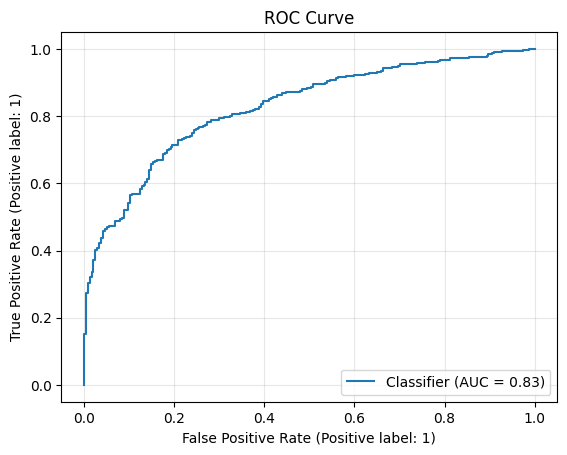

In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
import cv2
import shutil
import glob

# =======================
# Dataset & Preprocessing
# =======================
base_dir = "/kaggle/input/pneumonia"
train_dir = os.path.join(base_dir, "Pneumonia/train")
val_dir   = os.path.join(base_dir, "Pneumonia/val")
test_dir  = os.path.join(base_dir, "Pneumonia/test")

for d in [train_dir, val_dir, test_dir]:
    if not os.path.exists(d):
        raise FileNotFoundError(f"Missing: {d}")

train_aug = ImageDataGenerator(
    rescale=1./255, rotation_range=20, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode='nearest'
)
val_aug = ImageDataGenerator(rescale=1./255)
test_aug = ImageDataGenerator(rescale=1./255)

train_gen = train_aug.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
val_gen   = val_aug.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
test_gen  = test_aug.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

# =======================
# Class Weight
# =======================
classes = np.unique(train_gen.classes)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=train_gen.classes)
class_weights = dict(enumerate(cw))

# =======================
# Model
# =======================
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False

inp = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inp, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inp, out)

model.compile(optimizer=optimizers.Adam(0.001), loss="binary_crossentropy", metrics=["accuracy"])

# =======================
# Callbacks
# =======================
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint("/kaggle/working/best_model.keras", monitor='val_loss', save_best_only=True)
]

# =======================
# Training
# =======================
print("🔹 Training with frozen base...")
history = model.fit(
    train_gen, validation_data=val_gen, epochs=10,
    class_weight=class_weights, callbacks=callbacks, verbose=1
)

print("🔸 Fine-tuning base model...")
base_model.trainable = True
model.compile(optimizer=optimizers.Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"])
history_fine = model.fit(
    train_gen, validation_data=val_gen, epochs=10,
    class_weight=class_weights, callbacks=callbacks, verbose=1
)

# =======================
# Save model as .keras
# =======================
model.save("/kaggle/working/pneumonia_model_final.keras")
print("✅ Model saved to: /kaggle/working/pneumonia_model_final.keras")

# =======================
# Evaluation
# =======================
print("\nEvaluating on test set...")
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"🎯 Test Accuracy: {test_acc * 100:.2f}%")

y_true = test_gen.classes
y_pred_probs = model.predict(test_gen, verbose=0)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

conf = confusion_matrix(y_true, y_pred)
print("🧾 Confusion Matrix:\n", conf)
print("📝 Classification Report:\n", classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))
print(f"📈 AUROC: {roc_auc_score(y_true, y_pred_probs):.3f}")

plt.figure(figsize=(6, 5))
RocCurveDisplay.from_predictions(y_true, y_pred_probs)
plt.title("ROC Curve")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import cv2
from IPython.display import display, Image as IPyImage

# ============================
# 1. Load Model .keras
# ============================
model_path = "/kaggle/working/pneumonia_model_final.keras"
model = load_model(model_path)

# Ambil EfficientNetB0 sebagai base model dari Sequential
base_model = model.layers[0]

# Cari layer Conv2D terakhir
last_conv_layer_name = None
for layer in reversed(base_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

if last_conv_layer_name is None:
    raise ValueError("No Conv2D layer found!")

print(f"Using last conv layer: {last_conv_layer_name}")

# ============================
# 2. Fungsi Grad-CAM
# ============================
def make_gradcam_heatmap(img_array, model, base_model, last_conv_layer_name):
    grad_model = Model(
        [model.inputs],
        [base_model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]  # untuk klasifikasi biner
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()

def overlay_gradcam(img_path, heatmap, alpha=0.4):
    img = load_img(img_path)
    img = img_to_array(img)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    superimposed_img = heatmap_colored * alpha + img
    superimposed_img = np.uint8(np.clip(superimposed_img, 0, 255))
    return img.astype(np.uint8), heatmap_colored, superimposed_img

# ============================
# 3. Load Gambar dari Direktori Radiolog
# ============================
image_dir = "/kaggle/input/data-radiolog/data pneumonia radiolog 111124/data pneumonia radiolog 111124/data numbered14-10-24/26-09 (Sudah Blur)/BLM BLUR (Sudah Blur)"
output_dir = "/kaggle/working/gradcam_outputs_radiolog"
os.makedirs(output_dir, exist_ok=True)

image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")) +
                     glob.glob(os.path.join(image_dir, "*.jpeg")) +
                     glob.glob(os.path.join(image_dir, "*.png")))

print(f"Found {len(image_paths)} image(s) in: {image_dir}")

# ============================
# 4. Grad-CAM + Tampilkan di Notebook
# ============================
num_to_show = min(5, len(image_paths))

plt.figure(figsize=(15, num_to_show * 3))

for i, img_path in enumerate(image_paths[:num_to_show]):
    try:
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Grad-CAM
        heatmap = make_gradcam_heatmap(img_array, model, base_model, last_conv_layer_name)
        original, heatmap_color, superimposed = overlay_gradcam(img_path, heatmap)

        # Simpan hasil
        output_path = os.path.join(output_dir, f"gradcam_{i}.jpg")
        cv2.imwrite(output_path, cv2.cvtColor(superimposed, cv2.COLOR_RGB2BGR))

        # Plot
        plt.subplot(num_to_show, 3, i * 3 + 1)
        plt.imshow(original.astype("uint8"))
        plt.title("Original")
        plt.axis("off")

        plt.subplot(num_to_show, 3, i * 3 + 2)
        plt.imshow(heatmap_color[..., ::-1])  # BGR to RGB
        plt.title("Heatmap")
        plt.axis("off")

        plt.subplot(num_to_show, 3, i * 3 + 3)
        plt.imshow(superimposed)
        plt.title("Grad-CAM Overlay")
        plt.axis("off")

        print(f"[✓] Saved Grad-CAM: {output_path}")
    
    except Exception as e:
        print(f"[X] Error processing {img_path}: {e}")

plt.tight_layout()
plt.suptitle("Grad-CAM Visualization (Radiolog Dataset)", fontsize=16, y=1.02)
plt.show()